In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from openpyxl import load_workbook
from numba import jit

In [2]:
# Define the boundary and well radius
l = 4.0
r_out = 0.9
r_in = 0.1 + (r_out-0.9)     #well radius
b = r_out
w_h = 1.5   #well height
cap = 2.3   #cap height
eff_dep = 0.5   #position of effective depth of well
fps=30
# Define the diffusion coefficient and beta value
r_bead = 0.1
D_0 = 1.005
r_0 = 0.1
k = D_0*r_0
D = k/r_bead
beta = 3.0

# Define the step size and the total simulation time
dx = dy = dz = 0.04

# Choose the excel file to save data
path = "./"+str(D)+'_'+str(fps)+'Hz_no_well_step_size='+str(dx)+'_angle_trial3.xlsx'


0.12962962962962965


Text(0.5, 1.0, 'Geometric well')

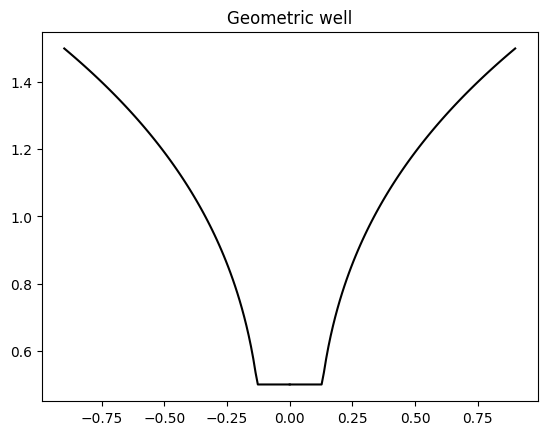

In [3]:
import warnings
# Well
eff_r_in = (r_out-r_in)*((((eff_dep-w_h)/w_h)+1)**3)+r_in
print(eff_r_in)
@jit(nopython=True)
def well_z(r):
    #warnings.filterwarnings("ignore")
    return (r > r_out)*w_h \
          +(r > eff_r_in)*(r <= r_out)*np.nan_to_num(-w_h*(1-((r-r_in)/(r_out-r_in))**(1/3))+w_h)\
          +(r <= eff_r_in)*eff_dep
@jit(nopython=True)
def well_r(z_pos):
    return (r_out-r_in)*((((z_pos-w_h)/w_h)+1)**3)+r_in
"""
@jit(nopython=True)
def well_z(r):
    #warnings.filterwarnings("ignore")
    return w_h*np.ones_like(r)
@jit(nopython=True)
def well_r(z_pos):
    return r_out
    """
r_span= np.linspace(0, r_out, 100)
z_span= np.linspace(eff_dep, w_h, 100)
plt.plot(r_span,well_z(r_span),color="black")
plt.plot(-r_span,well_z(r_span),color="black")
plt.title("Geometric well")
#plt.plot(z_span,well_r(z_span))

In [ ]:
import tqdm
import time
np.random.seed(seed=0)
# Define the position arrays for analysis

# Repeat the Gillespie Algorithm for N steps
@jit(nopython=True)
def shift(x):
    l=2
    return (x+l)%(2*l)-l
@jit(nopython=True)
def Gillispie_wander(L_max=10**3):
    #steps=10**5
    #x_track,y_track,z_track,t_track=np.zeros((4,steps))
    np.random.seed(seed=0)
    # Calculate a(v) for v = [0,6]
    a_v = D/dx**2
    a0 = a_v*6

    # Define the initial state of the nanoparticle
    x = 1.2
    y = 0.4
    z = 1.0
    t = 0.0
    radius = np.sqrt(x**2+y**2)
    #x_track[0],y_track[0],z_track[0],t_track[0]=x,y,z,t

    # IN = 1, OUT = 0
    if radius<=0.9:
        prev_in_well=1
    else:
        prev_in_well=0
    dwell_track=np.zeros((L_max))
    x_frame,y_frame,z_frame,t_frame=[x,x],[y,y],[z,z],[t,t]
    Z=[]
    enter_track,leave_track,angle_track=np.zeros((L_max,2)),np.zeros((L_max,2)),np.zeros((L_max))
    i=1
    L=0
    l=2
    while(L<L_max-1):
        x_frame,y_frame,z_frame,t_frame=[x_frame[-2],x_frame[-1]],[y_frame[-2],y_frame[-1]],[z_frame[-2],z_frame[-1]],[t_frame[-2],t_frame[-1]]
        while t < i/fps:
            # Generate 2 random number
            r1, r2 = np.random.uniform(low=0.0, high=1.0,size=2)

            # Calculate the time for movement
            tau = 1/a0*np.log(1/r1)

            # Choose the direction of the jump
            k = 1
            diff = r2*a0 - a_v

            while diff >= 0:
                k = k + 1
                diff = diff - a_v

            next_event = k

            # Update the position arrays
            if k == 1 and ((round(((x+dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x + dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 2 and ((round(((x-dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x - dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 3 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y + dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 4 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y-dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y - dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 5 and z+dz <= cap:
                z = z + dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 6 and z-dz >= well_z(np.sqrt(round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2)):
                z = z - dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
        x_frame.append((x_frame[-1]*(i/fps-t_frame[-2])+x_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        y_frame.append((y_frame[-1]*(i/fps-t_frame[-2])+y_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        z_frame.append((z_frame[-1]*(i/fps-t_frame[-2])+z_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        t_frame.append(i/fps)
        x_frame[-2],x_frame[-1]=x_frame[-1],x_frame[-2]
        y_frame[-2],y_frame[-1]=y_frame[-1],y_frame[-2]
        z_frame[-2],z_frame[-1]=z_frame[-1],z_frame[-2]
        t_frame[-2],t_frame[-1]=t_frame[-1],t_frame[-2]
        avg_x=np.trapz(x_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_y=np.trapz(y_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_z=np.trapz(z_frame[:-1],x=t_frame[:-1])/(1/fps)
        radius = np.sqrt(((avg_x+2.0)%(4.0)-2.0)**2+((avg_y+2.0)%(4.0)-2.0)**2)
        Z.append(avg_z)
        #x_track[i],y_track[i],z_track[i],t_track[i]=avg_x,avg_y,avg_z,i/fps
        
        # IN = 1, OUT = 0
        if radius <= 0.9:
            if prev_in_well==0:
                L+=1
                enter_track[L]=shift(np.array([avg_x,avg_y]))
            dwell_track[L]+=1/fps
            prev_in_well=1
        else:
            if prev_in_well==1:
                leave_track[L]=shift(np.array([avg_x,avg_y]))
                angle_track[L]=np.abs(np.arctan2(leave_track[L,1],leave_track[L,0])-np.arctan2(enter_track[L,1],enter_track[L,0]))
            prev_in_well=0
        i=i+1
    return dwell_track,angle_track,Z
start_time=time.time()
dwell_track,angle_track,z=Gillispie_wander(L_max=10**3)
end_time=time.time()
print(end_time-start_time)



2.2006843090057373


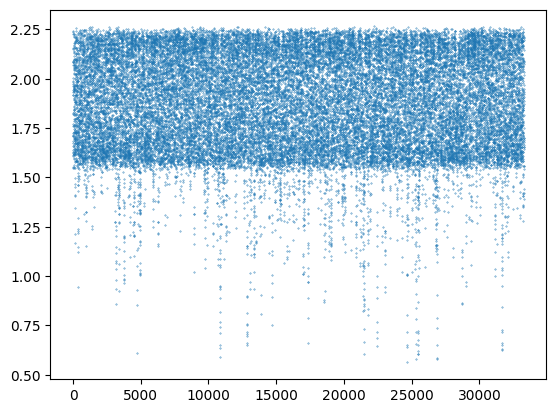

In [6]:
plt.scatter(np.arange(len(z)),z,s=0.1)

Vanilla Gillipise:57.21725916862488

Jit python Gillispie:3.4

10**3: 3.4

10**4:9.3

10**5: 31.87

10**6: 10 min

In [ ]:
import tqdm
import time
np.random.seed(seed=0)
# Define the position arrays for analysis

# Repeat the Gillespie Algorithm for N steps
@jit(nopython=True)
def shift(x):
    l=2
    return (x+l)%(2*l)-l
@jit(nopython=True)
def Gillispie_restart(L_max=10**3):
    #steps=10**5
    #x_track,y_track,z_track,t_track=np.zeros((4,steps))
    np.random.seed(seed=0)
    # Calculate a(v) for v = [0,6]
    a_v = D/dx**2
    a0 = a_v*6

    # Define the initial state of the nanoparticle
    x = 1.2
    y = 0.4
    z = 1.0
    t = 0.0
    dwell_track,t_enter_track,t_leave_track=np.zeros((3,L_max))
    x_frame,y_frame,z_frame,t_frame=[x,x],[y,y],[z,z],[t,t]
    Z=[]
    enter_track,leave_track,angle_track=np.zeros((L_max,2)),np.zeros((L_max,2)),np.zeros((L_max))
    i=1
    L=0
    l=2
    while(L<L_max-1):
        x_frame,y_frame,z_frame,t_frame=[x_frame[-2],x_frame[-1]],[y_frame[-2],y_frame[-1]],[z_frame[-2],z_frame[-1]],[t_frame[-2],t_frame[-1]]
        while t < i/fps:
            # Generate 2 random number
            r1, r2 = np.random.uniform(low=0.0, high=1.0,size=2)

            # Calculate the time for movement
            tau = 1/a0*np.log(1/r1)

            # Choose the direction of the jump
            k = 1
            diff = r2*a0 - a_v

            while diff >= 0:
                k = k + 1
                diff = diff - a_v

            next_event = k

            # Update the position arrays
            if k == 1 and ((round(((x+dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x + dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 2 and ((round(((x-dx+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                x = x - dx
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 3 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y + dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 4 and ((round(((x+2.0)%(4.0)-2.0),2)**2+round(((y-dy+2.0)%(4.0)-2.0),2)**2) <= (well_r(z))**2 or z >= w_h):
                y = y - dy
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 5 and z+dz <= cap:
                z = z + dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
            elif k == 6 and z-dz >= well_z(np.sqrt(round(((x+2.0)%(4.0)-2.0),2)**2+round(((y+2.0)%(4.0)-2.0),2)**2)):
                z = z - dz
                t = t + tau
                x_frame.append(x),y_frame.append(y),z_frame.append(z),t_frame.append(t)
        x_frame.append((x_frame[-1]*(i/fps-t_frame[-2])+x_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        y_frame.append((y_frame[-1]*(i/fps-t_frame[-2])+y_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        z_frame.append((z_frame[-1]*(i/fps-t_frame[-2])+z_frame[-2]*(t_frame[-1]-i/fps))/(t_frame[-1]-t_frame[-2]))
        t_frame.append(i/fps)
        x_frame[-2],x_frame[-1]=x_frame[-1],x_frame[-2]
        y_frame[-2],y_frame[-1]=y_frame[-1],y_frame[-2]
        z_frame[-2],z_frame[-1]=z_frame[-1],z_frame[-2]
        t_frame[-2],t_frame[-1]=t_frame[-1],t_frame[-2]
        avg_x=np.trapz(x_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_y=np.trapz(y_frame[:-1],x=t_frame[:-1])/(1/fps)
        avg_z=np.trapz(z_frame[:-1],x=t_frame[:-1])/(1/fps)
        radius = np.sqrt(((avg_x+2.0)%(4.0)-2.0)**2+((avg_y+2.0)%(4.0)-2.0)**2)
        Z.append(avg_z)
        #x_track[i],y_track[i],z_track[i],t_track[i]=avg_x,avg_y,avg_z,i/fps
        
        # IN = 1, OUT = 0
        if radius <= 0.9:
            if prev_in_well==0:
                L+=1
                enter_track[L]=shift(np.array([avg_x,avg_y]))
            dwell_track[L]+=1/fps
            prev_in_well=1
        else:
            if prev_in_well==1:
                leave_track[L]=shift(np.array([avg_x,avg_y]))
                angle_track[L]=np.abs(np.arctan2(leave_track[L,1],leave_track[L,0])-np.arctan2(enter_track[L,1],enter_track[L,0]))
            prev_in_well=0
        i=i+1
    return dwell_track,angle_track,Z
start_time=time.time()
dwell_track,angle_track,z=Gillispie_wander(L_max=10**3)
end_time=time.time()
print(end_time-start_time)



In [5]:
import numpy as np
import pandas as pd
from openpyxl import load_workbook

In [37]:
print(angle_track.shape)
#print(leave_track)

(1000000,)


In [74]:
with pd.ExcelWriter(path, engine='openpyxl') as writer:
	d = {'dwell_time': dwell_track[1:-1],"angle":angle_track[1:-1]}
	df = pd.DataFrame(data = d)
	df.to_excel(writer, index = True, sheet_name = 'dwell time')
	#d = {'x': x_track[:i],'y':y_track[:i],'z':z_track[:i],'t':t_track[:i]}
	df = pd.DataFrame(data = d)
	df.to_excel(writer, index=True, sheet_name = 'trajectory')

In [39]:
"""
import plotly.express as px
import plotly.graph_objects as go

fig =go.Figure(data=px.scatter_3d(df, x='x', y='y', z='z',color='t'))
x_scale=np.max(df['x'])-np.min(df['x'])
y_scale=np.max(df['y'])-np.min(df['y'])
Max=max(x_scale,y_scale)
fig.update_traces(marker_size = 3)
fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        aspectratio = dict( x=x_scale*0.9/Max, y=y_scale/Max, z=0.7),
        aspectmode = 'manual'
    ),
)
#for i in range(-2,2):
    #for j in range(-4,1):
        #fig.add_trace(go.Surface(z=Z, x=x+i*l, y=y+j*l, opacity=0.5, colorscale='Blues'))
fig.show()
"""

"\nimport plotly.express as px\nimport plotly.graph_objects as go\n\nfig =go.Figure(data=px.scatter_3d(df, x='x', y='y', z='z',color='t'))\nx_scale=np.max(df['x'])-np.min(df['x'])\ny_scale=np.max(df['y'])-np.min(df['y'])\nMax=max(x_scale,y_scale)\nfig.update_traces(marker_size = 3)\nfig.update_layout(\n    width=800,\n    height=700,\n    autosize=False,\n    scene=dict(\n        aspectratio = dict( x=x_scale*0.9/Max, y=y_scale/Max, z=0.7),\n        aspectmode = 'manual'\n    ),\n)\n#for i in range(-2,2):\n    #for j in range(-4,1):\n        #fig.add_trace(go.Surface(z=Z, x=x+i*l, y=y+j*l, opacity=0.5, colorscale='Blues'))\nfig.show()\n"

[-1.35 -1.05 -0.75 -0.45 -0.15  0.15  0.45]


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


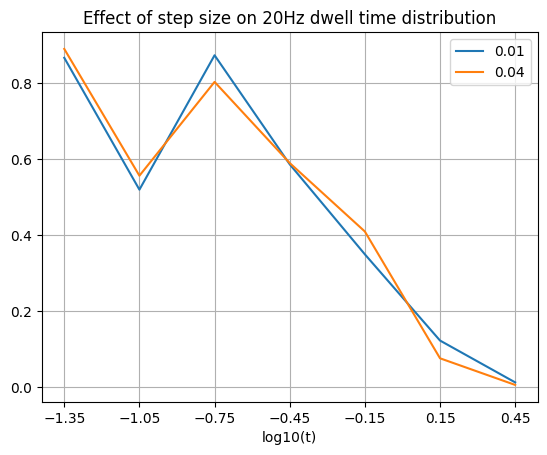

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
path1 = './1.005_20Hz_step_size=0.01_trial1.xlsx'
path2 = './1.005_20Hz_step_size=0.04_trial1.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')
data2 = pd.read_excel(path2, sheet_name='dwell time')
bin_edge1=np.arange(-1.5,0.9,0.3)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
hist1,bin1= np.histogram(np.log10(data1), bins = bin_edge1,density=True)
hist2,bin2= np.histogram(np.log10(data2), bins = bin_edge1,density=True)
print(bin_center1)
plt.plot(bin_center1,hist1,label='0.01')
plt.plot(bin_center1,hist2,label='0.04')
plt.title("Effect of step size on 20Hz dwell time distribution")
plt.xticks(bin_center1)
plt.xlabel("log10(t)")
plt.grid()
plt.legend()

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
path1 = './1.005_30Hz_step_size=0.04_angle.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')
path2 = './1.005_30Hz_step_size=0.04_angle_below_z.xlsx'
data2 = pd.read_excel(path2, sheet_name='dwell time')

(999998,)


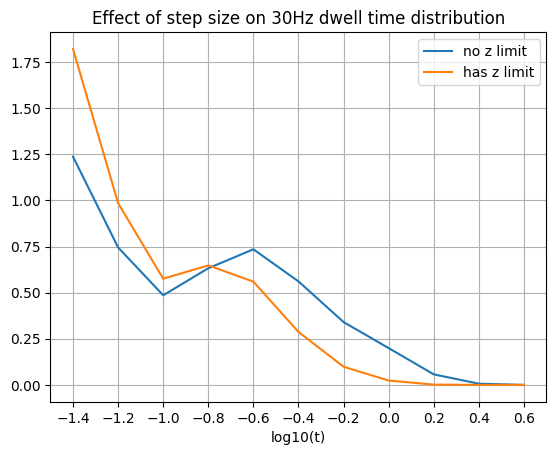

In [97]:

bin_edge1=np.arange(-1.5,0.9,0.2)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
Time=data1['dwell_time']
Time2=data2['dwell_time']
print(Time.shape)
angle=data1['angle']
angle_10=Time[angle<=10/180*np.pi]
angle_30=Time[angle<=30/180*np.pi]
angle_50=Time[angle<=50/180*np.pi]
angle_90=Time[angle<=90/180*np.pi]
angle_180=Time[angle<=180/180*np.pi]
#hist1,bin1= np.histogram(np.log10(data1['dwell_time']), bins = bin_edge1,density=True)
hist10,bin10= np.histogram(np.log10(Time), bins = bin_edge1,density=True)
hist20,bin10= np.histogram(np.log10(Time2), bins = bin_edge1,density=True)
#hist30,bin30= np.histogram(np.log10(angle_30), bins = bin_edge1,density=True)
#hist50,bin50= np.histogram(np.log10(angle_50), bins = bin_edge1,density=True)
#hist90,bin90= np.histogram(np.log10(angle_90), bins = bin_edge1,density=True)
#hist180,bin180= np.histogram(np.log10(angle_180), bins = bin_edge1,density=True)
#hist2,bin2= np.histogram(np.log10(data2), bins = bin_edge1,density=True)
plt.plot(bin_center1,hist10,label='no z limit')
plt.plot(bin_center1,hist20,label='has z limit')
#plt.plot(bin_center1,hist30,label='angle<=30')
#plt.plot(bin_center1,hist50,label='angle<=50')
#plt.plot(bin_center1,hist90,label='angle<=90')
#plt.plot(bin_center1,hist180,label='angle<=180')
plt.title("Effect of step size on 30Hz dwell time distribution")
plt.xticks(bin_center1)
plt.xlabel("log10(t)")
plt.grid()
plt.legend()

(999998,)


C:\Users\User\AppData\Local\Temp\ipykernel_60488\2761555416.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


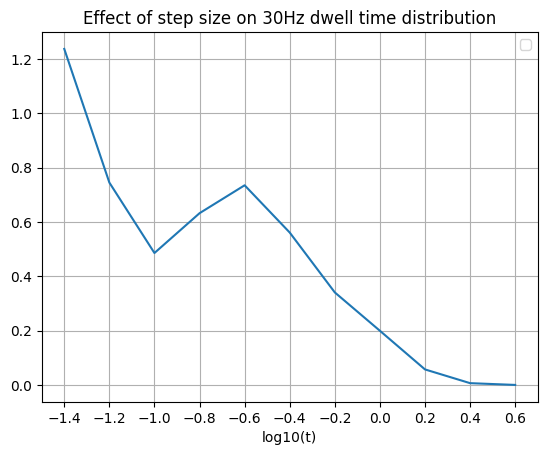

In [20]:

bin_edge1=np.arange(-1.5,0.9,0.2)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
Time=data1['dwell_time']
print(Time.shape)
angle=data1['angle']
angle_10=Time[angle<=10/180*np.pi]
angle_30=Time[angle<=30/180*np.pi]
angle_50=Time[angle<=50/180*np.pi]
angle_90=Time[angle<=90/180*np.pi]
angle_180=Time[angle<=180/180*np.pi]
#hist1,bin1= np.histogram(np.log10(data1['dwell_time']), bins = bin_edge1,density=True)
hist10,bin10= np.histogram(np.log10(Time), bins = bin_edge1,density=True)
#hist30,bin30= np.histogram(np.log10(angle_30), bins = bin_edge1,density=True)
#hist50,bin50= np.histogram(np.log10(angle_50), bins = bin_edge1,density=True)
#hist90,bin90= np.histogram(np.log10(angle_90), bins = bin_edge1,density=True)
#hist180,bin180= np.histogram(np.log10(angle_180), bins = bin_edge1,density=True)
#hist2,bin2= np.histogram(np.log10(data2), bins = bin_edge1,density=True)
plt.plot(bin_center1,hist10)
#plt.plot(bin_center1,hist30,label='angle<=30')
#plt.plot(bin_center1,hist50,label='angle<=50')
#plt.plot(bin_center1,hist90,label='angle<=90')
#plt.plot(bin_center1,hist180,label='angle<=180')
plt.title("Effect of step size on 30Hz dwell time distribution")
plt.xticks(bin_center1)
plt.xlabel("log10(t)")
plt.grid()
plt.legend()

(999998,)


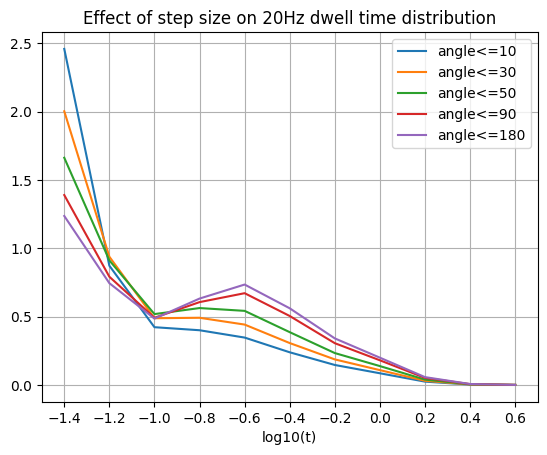

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
path1 = './1.005_30Hz_step_size=0.04_angle.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')
bin_edge1=np.arange(-1.5,0.9,0.2)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
Time=data1['dwell_time']
print(Time.shape)
angle=data1['angle']
angle_10=Time[angle<=10/180*np.pi]
angle_30=Time[angle<=30/180*np.pi]
angle_50=Time[angle<=50/180*np.pi]
angle_90=Time[angle<=90/180*np.pi]
angle_180=Time[angle<=180/180*np.pi]
#hist1,bin1= np.histogram(np.log10(data1['dwell_time']), bins = bin_edge1,density=True)
hist10,bin10= np.histogram(np.log10(angle_10), bins = bin_edge1,density=True)
hist30,bin30= np.histogram(np.log10(angle_30), bins = bin_edge1,density=True)
hist50,bin50= np.histogram(np.log10(angle_50), bins = bin_edge1,density=True)
hist90,bin90= np.histogram(np.log10(angle_90), bins = bin_edge1,density=True)
hist180,bin180= np.histogram(np.log10(angle_180), bins = bin_edge1,density=True)
plt.plot(bin_center1,hist10,label='angle<=10')
plt.plot(bin_center1,hist30,label='angle<=30')
plt.plot(bin_center1,hist50,label='angle<=50')
plt.plot(bin_center1,hist90,label='angle<=90')
plt.plot(bin_center1,hist180,label='angle<=180')
plt.title("Effect of step size on 20Hz dwell time distribution")
plt.xticks(bin_center1)
plt.xlabel("log10(t)")
plt.grid()
plt.legend()

[-1.40000000e+00 -1.20000000e+00 -1.00000000e+00 -8.00000000e-01
 -6.00000000e-01 -4.00000000e-01 -2.00000000e-01 -3.33066907e-16
  2.00000000e-01  4.00000000e-01  6.00000000e-01]


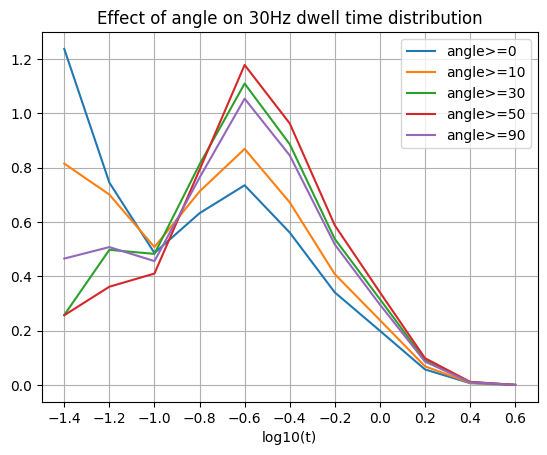

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
path1 = './1.005_30Hz_step_size=0.04_angle.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')
bin_edge1=np.arange(-1.5,0.9,0.2)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
Time=data1['dwell_time']
angle=data1['angle']
angle_10=Time[angle>=10/180*np.pi]
angle_30=Time[angle>=30/180*np.pi]
angle_50=Time[angle>=50/180*np.pi]
angle_90=Time[angle>=90/180*np.pi]
angle_180=Time[angle>=0]
#hist1,bin1= np.histogram(np.log10(data1['dwell_time']), bins = bin_edge1,density=True)
hist10,bin10= np.histogram(np.log10(angle_10), bins = bin_edge1,density=True)
hist30,bin30= np.histogram(np.log10(angle_30), bins = bin_edge1,density=True)
hist50,bin50= np.histogram(np.log10(angle_50), bins = bin_edge1,density=True)
hist90,bin90= np.histogram(np.log10(angle_90), bins = bin_edge1,density=True)
hist180,bin180= np.histogram(np.log10(angle_180), bins = bin_edge1,density=True)
#hist2,bin2= np.histogram(np.log10(data2), bins = bin_edge1,density=True)
print(bin_center1)
plt.plot(bin_center1,hist180,label='angle>=0')
plt.plot(bin_center1,hist10,label='angle>=10')
plt.plot(bin_center1,hist30,label='angle>=30')
plt.plot(bin_center1,hist50,label='angle>=50')
plt.plot(bin_center1,hist90,label='angle>=90')
plt.title("Effect of angle on 30Hz dwell time distribution")
plt.xticks(bin_center1)
plt.xlabel("log10(t)")
plt.grid()
plt.legend()

[-1.55 -1.35 -1.15 -0.95 -0.75 -0.55 -0.35 -0.15  0.05  0.25  0.45  0.65]


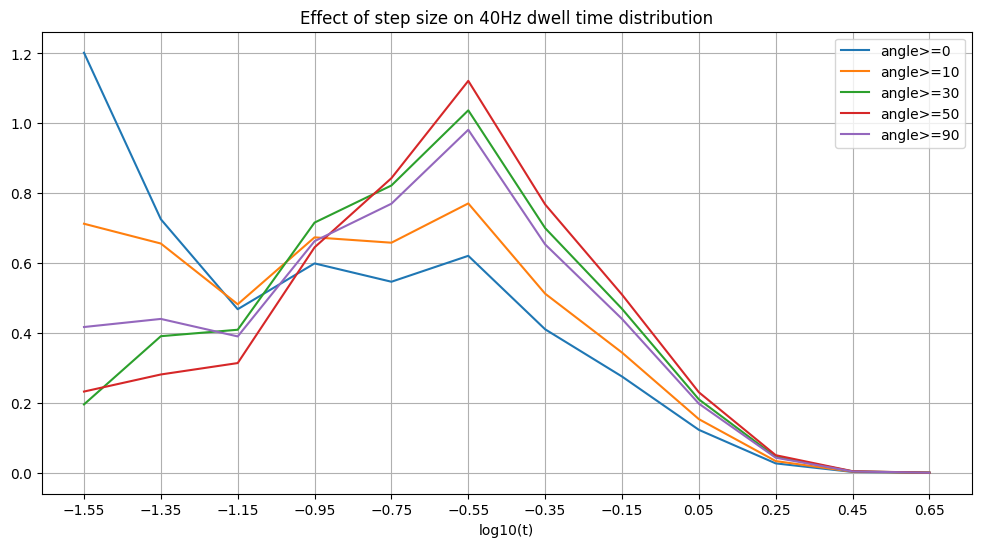

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
path1 = './1.005_40Hz_step_size=0.04_angle.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')
bin_edge1=np.arange(-1.65,0.9,0.2)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
Time=data1['dwell_time']
angle=data1['angle']
angle_10=Time[angle>=10/180*np.pi]
angle_30=Time[angle>=30/180*np.pi]
angle_50=Time[angle>=50/180*np.pi]
angle_90=Time[angle>=90/180*np.pi]
angle_180=Time[angle>=0]
#hist1,bin1= np.histogram(np.log10(data1['dwell_time']), bins = bin_edge1,density=True)
hist10,bin10= np.histogram(np.log10(angle_10), bins = bin_edge1,density=True)
hist30,bin30= np.histogram(np.log10(angle_30), bins = bin_edge1,density=True)
hist50,bin50= np.histogram(np.log10(angle_50), bins = bin_edge1,density=True)
hist90,bin90= np.histogram(np.log10(angle_90), bins = bin_edge1,density=True)
hist180,bin180= np.histogram(np.log10(angle_180), bins = bin_edge1,density=True)
#hist2,bin2= np.histogram(np.log10(data2), bins = bin_edge1,density=True)
print(bin_center1)
plt.figure(figsize=(12, 6))
plt.plot(bin_center1,hist180,label='angle>=0')
plt.plot(bin_center1,hist10,label='angle>=10')
plt.plot(bin_center1,hist30,label='angle>=30')
plt.plot(bin_center1,hist50,label='angle>=50')
plt.plot(bin_center1,hist90,label='angle>=90')
plt.title("Effect of step size on 40Hz dwell time distribution")
plt.xticks(bin_center1)
plt.xlabel("log10(t)")
plt.grid()
plt.legend()

[-1.685 -1.455 -1.225 -0.995 -0.765 -0.535 -0.305 -0.075  0.155  0.385
  0.615]


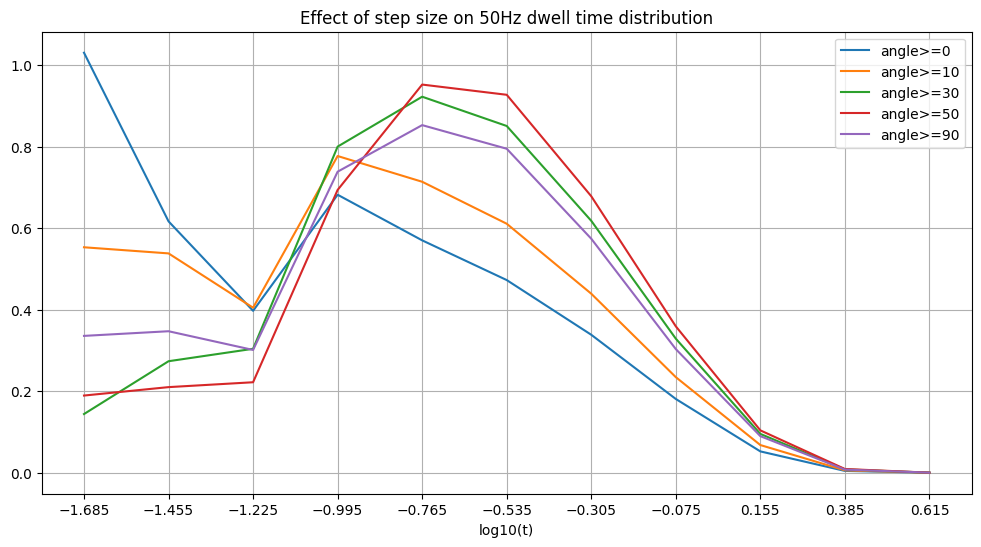

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
path1 = './1.005_50Hz_step_size=0.04_angle.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')
bin_edge1=np.arange(-1.8,0.9,0.23)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
Time=data1['dwell_time']
angle=data1['angle']
angle_10=Time[angle>=10/180*np.pi]
angle_30=Time[angle>=30/180*np.pi]
angle_50=Time[angle>=50/180*np.pi]
angle_90=Time[angle>=90/180*np.pi]
angle_180=Time[angle>=0]
#hist1,bin1= np.histogram(np.log10(data1['dwell_time']), bins = bin_edge1,density=True)
hist10,bin10= np.histogram(np.log10(angle_10), bins = bin_edge1,density=True)
hist30,bin30= np.histogram(np.log10(angle_30), bins = bin_edge1,density=True)
hist50,bin50= np.histogram(np.log10(angle_50), bins = bin_edge1,density=True)
hist90,bin90= np.histogram(np.log10(angle_90), bins = bin_edge1,density=True)
hist180,bin180= np.histogram(np.log10(angle_180), bins = bin_edge1,density=True)
#hist2,bin2= np.histogram(np.log10(data2), bins = bin_edge1,density=True)
print(bin_center1)
plt.figure(figsize=(12, 6))
plt.plot(bin_center1,hist180,label='angle>=0')
plt.plot(bin_center1,hist10,label='angle>=10')
plt.plot(bin_center1,hist30,label='angle>=30')
plt.plot(bin_center1,hist50,label='angle>=50')
plt.plot(bin_center1,hist90,label='angle>=90')
plt.title("Effect of step size on 50Hz dwell time distribution")
plt.xticks(bin_center1)
plt.xlabel("log10(t)")
plt.grid()
plt.legend()

[-1.685 -1.455 -1.225 -0.995 -0.765 -0.535 -0.305 -0.075  0.155  0.385
  0.615]


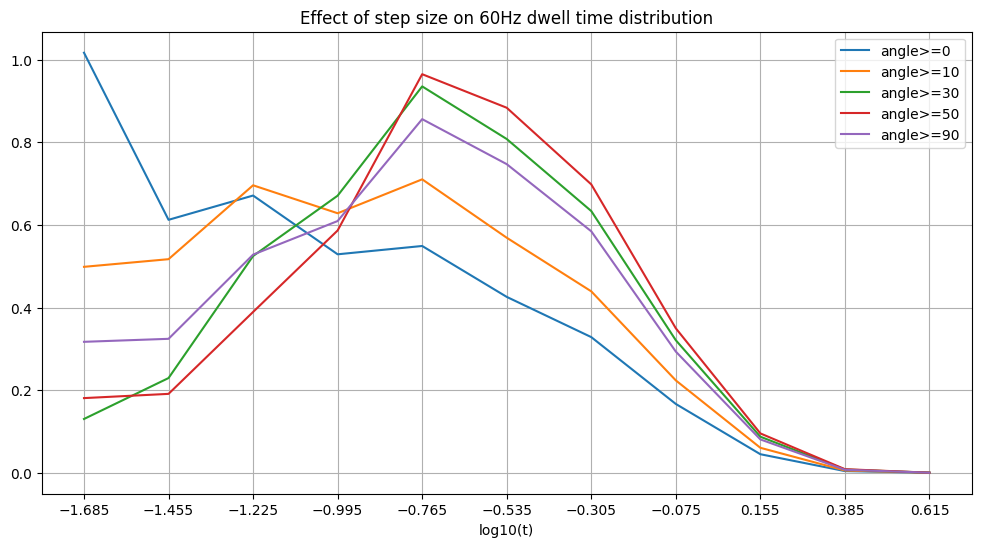

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
path1 = './1.005_60Hz_step_size=0.04_angle.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')
bin_edge1=np.arange(-1.8,0.9,0.23)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
Time=data1['dwell_time']
angle=data1['angle']
angle_10=Time[angle>=10/180*np.pi]
angle_30=Time[angle>=30/180*np.pi]
angle_50=Time[angle>=50/180*np.pi]
angle_90=Time[angle>=90/180*np.pi]
angle_180=Time[angle>=0]
#hist1,bin1= np.histogram(np.log10(data1['dwell_time']), bins = bin_edge1,density=True)
hist10,bin10= np.histogram(np.log10(angle_10), bins = bin_edge1,density=True)
hist30,bin30= np.histogram(np.log10(angle_30), bins = bin_edge1,density=True)
hist50,bin50= np.histogram(np.log10(angle_50), bins = bin_edge1,density=True)
hist90,bin90= np.histogram(np.log10(angle_90), bins = bin_edge1,density=True)
hist180,bin180= np.histogram(np.log10(angle_180), bins = bin_edge1,density=True)
#hist2,bin2= np.histogram(np.log10(data2), bins = bin_edge1,density=True)
print(bin_center1)
plt.figure(figsize=(12, 6))
plt.plot(bin_center1,hist180,label='angle>=0')
plt.plot(bin_center1,hist10,label='angle>=10')
plt.plot(bin_center1,hist30,label='angle>=30')
plt.plot(bin_center1,hist50,label='angle>=50')
plt.plot(bin_center1,hist90,label='angle>=90')
plt.title("Effect of step size on 60Hz dwell time distribution")
plt.xticks(bin_center1)
plt.xlabel("log10(t)")
plt.grid()
plt.legend()

In [ ]:
path0 = './1.005_30Hz_no_well_step_size=0.04_angle.xlsx'
data0 = pd.read_excel(path0, sheet_name='dwell time')

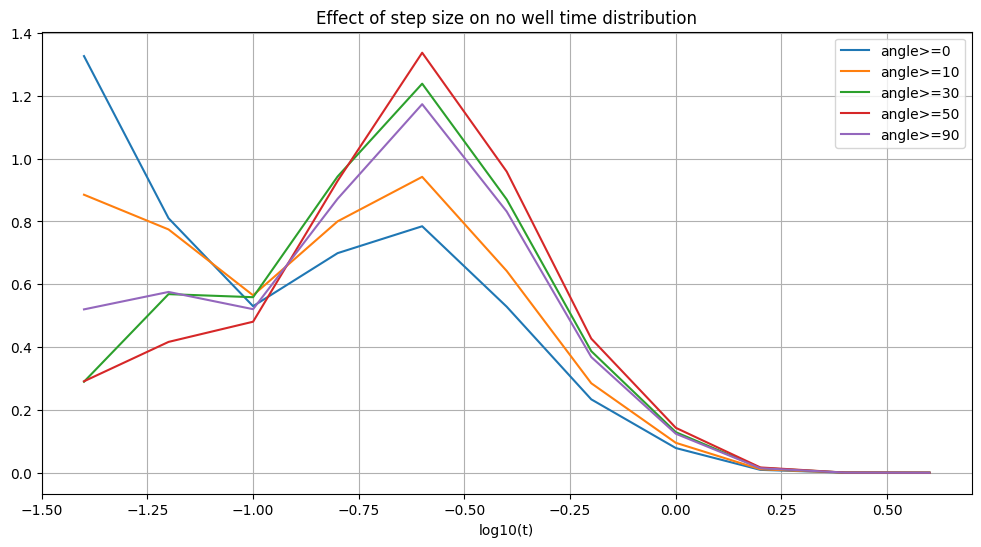

In [50]:
bin_edge0=np.arange(-1.5,0.9,0.2)
bin_center0 = (bin_edge0[:-1] + bin_edge0[1:]) / 2
Time=data0['dwell_time']
angle=data0['angle']
angle_10=Time[angle>=10/180*np.pi]
angle_30=Time[angle>=30/180*np.pi]
angle_50=Time[angle>=50/180*np.pi]
angle_90=Time[angle>=90/180*np.pi]
angle_180=Time[angle>=0]
#hist1,bin1= np.histogram(np.log10(data1['dwell_time']), bins = bin_edge1,density=True)
hist10,bin10= np.histogram(np.log10(angle_10), bins = bin_edge0,density=True)
hist30,bin30= np.histogram(np.log10(angle_30), bins = bin_edge0,density=True)
hist50,bin50= np.histogram(np.log10(angle_50), bins = bin_edge0,density=True)
hist90,bin90= np.histogram(np.log10(angle_90), bins = bin_edge0,density=True)
hist180,bin180= np.histogram(np.log10(angle_180), bins = bin_edge0,density=True)
#hist2,bin2= np.histogram(np.log10(data2), bins = bin_edge1,density=True)
plt.figure(figsize=(12, 6))
plt.plot(bin_center0,hist180,label='angle>=0')
plt.plot(bin_center0,hist10,label='angle>=10')
plt.plot(bin_center0,hist30,label='angle>=30')
plt.plot(bin_center0,hist50,label='angle>=50')
plt.plot(bin_center0,hist90,label='angle>=90')
plt.title("Effect of step size on no well time distribution")
#plt.xticks(bin_center1)
plt.xlabel("log10(t)")
plt.grid()
plt.legend()

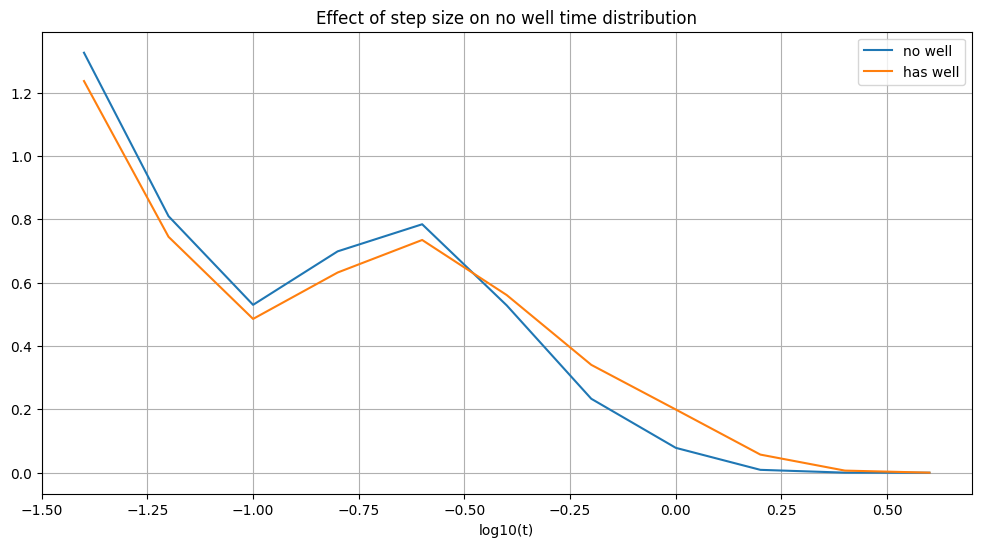

In [56]:
bin_edge0=np.arange(-1.5,0.9,0.2)
bin_center0 = (bin_edge0[:-1] + bin_edge0[1:]) / 2
Time=data0['dwell_time']
angle=data0['angle']
angle_0=Time[angle>=0]
Time1=data1['dwell_time']
angle1=data1['angle']
angle_1=Time1[angle1>=0]
#hist1,bin1= np.histogram(np.log10(data1['dwell_time']), bins = bin_edge1,density=True)
hist0,bin= np.histogram(np.log10(angle_0), bins = bin_edge0,density=True)
hist1,bin= np.histogram(np.log10(angle_1), bins = bin_edge0,density=True)
#hist2,bin2= np.histogram(np.log10(data2), bins = bin_edge1,density=True)
plt.figure(figsize=(12, 6))
plt.plot(bin_center0,hist0,label='no well')
plt.plot(bin_center0,hist1,label='has well')
plt.title("Effect of step size on no well time distribution")
#plt.xticks(bin_center1)
plt.xlabel("log10(t)")
plt.grid()
plt.legend()

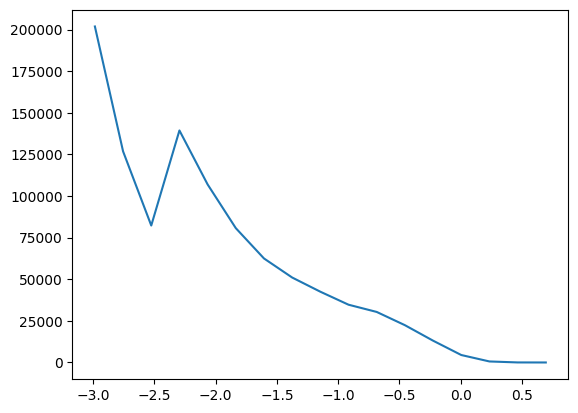

In [ ]:
hist5,bin5= np.histogram(np.log10(Time5), bins = bin_edge5)
angle_10=Time5[angle5>=10/180*np.pi]
angle_30=Time5[angle5>=30/180*np.pi]
angle_50=Time5[angle>=50/180*np.pi]
angle_90=Time5[angle>=90/180*np.pi]
angle_180=Time5[angle>=0]
#hist1,bin1= np.histogram(np.log10(data1['dwell_time']), bins = bin_edge1,density=True)
hist10,bin10= np.histogram(np.log10(angle_10), bins = bin_edge1,density=True)
hist30,bin30= np.histogram(np.log10(angle_30), bins = bin_edge1,density=True)
hist50,bin50= np.histogram(np.log10(angle_50), bins = bin_edge1,density=True)
hist90,bin90= np.histogram(np.log10(angle_90), bins = bin_edge1,density=True)
hist180,bin180= np.histogram(np.log10(angle_180), bins = bin_edge1,density=True)
plt.plot(bin_center1,hist180,label='angle>=0')
plt.plot(bin_center1,hist10,label='angle>=10')
plt.plot(bin_center1,hist30,label='angle>=30')
plt.plot(bin_center1,hist50,label='angle>=50')
plt.plot(bin_center1,hist90,label='angle>=90')

In [17]:
path1 = './1.005_30Hz_step_size=0.04_angle.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')
path2 = './1.005_40Hz_step_size=0.04_angle.xlsx'
data2 = pd.read_excel(path2, sheet_name='dwell time')
path3 = './1.005_50Hz_step_size=0.04_angle.xlsx'
data3 = pd.read_excel(path3, sheet_name='dwell time')
path4 = './1.005_60Hz_step_size=0.04_angle.xlsx'
data4 = pd.read_excel(path4, sheet_name='dwell time')
path5 = './1.005_1000Hz_step_size=0.04_angle.xlsx'
data5= pd.read_excel(path5, sheet_name='dwell time')

Text(0.5, 1.0, 'Effect of frequency on dwell time distribution of angle>=50')

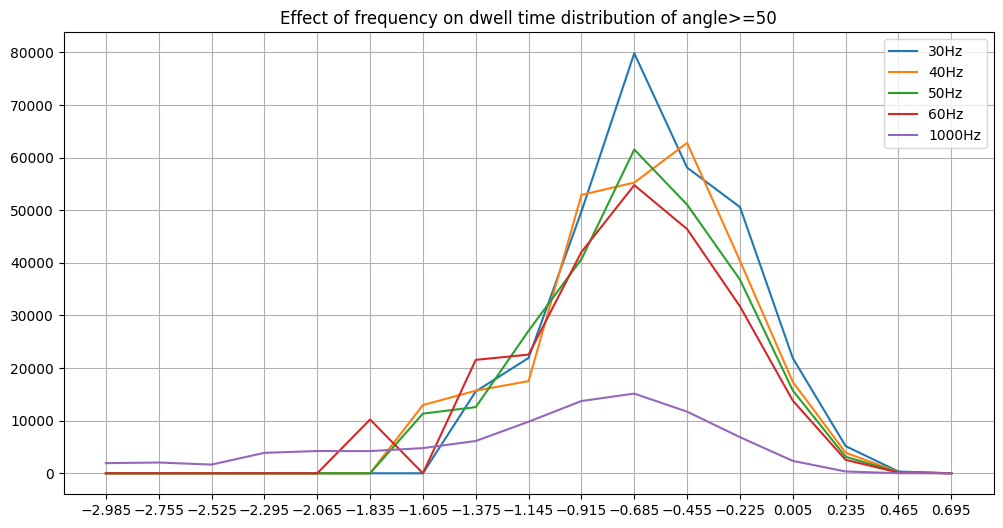

In [14]:

bin_edge1=np.arange(-1.5,0.9,0.23)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
bin_edge2=np.arange(-1.65,0.9,0.23)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2
bin_edge3=np.arange(-1.8,0.9,0.23)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2
bin_edge4=np.arange(-1.8,0.9,0.23)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2
bin_edge5=np.arange(-3.1,0.9,0.23)
bin_center5= (bin_edge5[:-1] + bin_edge5[1:]) / 2
Time1=data1['dwell_time']
Time2=data2['dwell_time']
Time3=data3['dwell_time']
Time4=data4['dwell_time']
Time5=data5['dwell_time']
angle1=data1['angle']
angle2=data2['angle']
angle3=data3['angle']
angle4=data4['angle']
angle5=data5['angle']
angle_1=Time1[angle1>=50/180*np.pi]
angle_2=Time2[angle2>=50/180*np.pi]
angle_3=Time3[angle3>=50/180*np.pi]
angle_4=Time4[angle4>=50/180*np.pi]
angle_5=Time5[angle5>=50/180*np.pi]
hist1,bin1= np.histogram(np.log10(angle_1), bins = bin_edge5)
hist2,bin2= np.histogram(np.log10(angle_2), bins = bin_edge5)
hist3,bin3= np.histogram(np.log10(angle_3), bins = bin_edge5)
hist4,bin4= np.histogram(np.log10(angle_4), bins = bin_edge5)
hist5,bin5= np.histogram(np.log10(angle_5), bins = bin_edge5)
plt.figure(figsize=(12, 6))
plt.plot(bin_center5,hist1,label='30Hz')
plt.plot(bin_center5,hist2,label='40Hz')
plt.plot(bin_center5,hist3,label='50Hz')
plt.plot(bin_center5,hist4,label='60Hz')
plt.plot(bin_center5,hist5,label='1000Hz')
plt.legend()
plt.xticks(bin_center5)
plt.grid()
plt.title("Effect of frequency on dwell time distribution of angle>=50")

Text(0.5, 1.0, 'Effect of frequency on dwell time distribution of angle>=50')

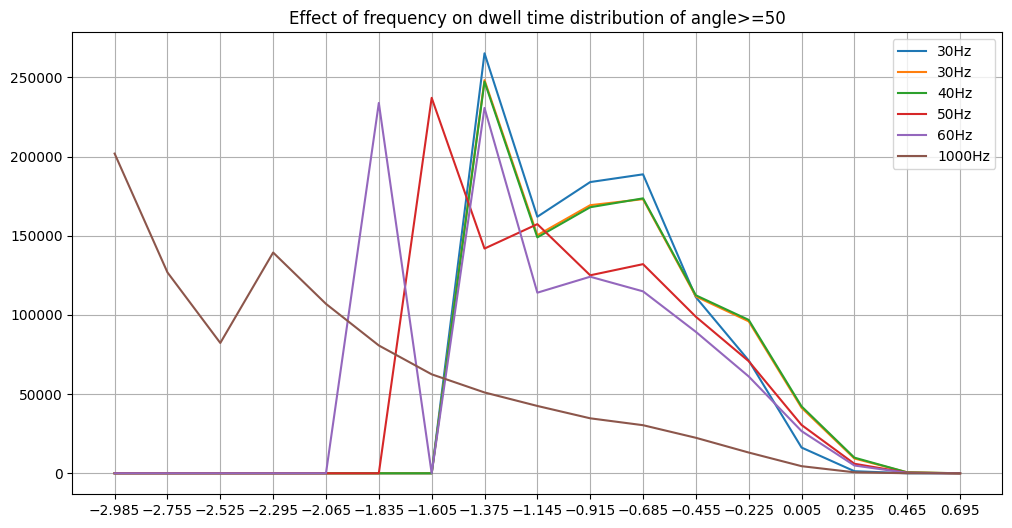

In [83]:
bin_edge0=np.arange(-1.5,0.9,0.23)
bin_center0 = (bin_edge0[:-1] + bin_edge0[1:]) / 2
bin_edge1=np.arange(-1.5,0.9,0.23)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
bin_edge2=np.arange(-1.65,0.9,0.23)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2
bin_edge3=np.arange(-1.8,0.9,0.23)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2
bin_edge4=np.arange(-1.8,0.9,0.23)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2
bin_edge5=np.arange(-3.1,0.9,0.23)
bin_center5= (bin_edge5[:-1] + bin_edge5[1:]) / 2
Time0=data0['dwell_time']
Time1=data1['dwell_time']
Time2=data2['dwell_time']
Time3=data3['dwell_time']
Time4=data4['dwell_time']
Time5=data5['dwell_time']
angle0=data0['angle']
angle1=data1['angle']
angle2=data2['angle']
angle3=data3['angle']
angle4=data4['angle']
angle5=data5['angle']
angle_0=Time0[angle0<=180/180*np.pi]
angle_1=Time1[angle1<=180/180*np.pi]
angle_2=Time2[angle2<=180/180*np.pi]
angle_3=Time3[angle3<=180/180*np.pi]
angle_4=Time4[angle4<=180/180*np.pi]
angle_5=Time5[angle5<=180/180*np.pi]
hist0,bin0= np.histogram(np.log10(angle_0), bins = bin_edge5)
hist1,bin1= np.histogram(np.log10(angle_1), bins = bin_edge5)
hist2,bin2= np.histogram(np.log10(angle_2), bins = bin_edge5)
hist3,bin3= np.histogram(np.log10(angle_3), bins = bin_edge5)
hist4,bin4= np.histogram(np.log10(angle_4), bins = bin_edge5)
hist5,bin5= np.histogram(np.log10(angle_5), bins = bin_edge5)
plt.figure(figsize=(12, 6))
plt.plot(bin_center5,hist0,label='30Hz')
plt.plot(bin_center5,hist1,label='30Hz')
plt.plot(bin_center5,hist2,label='40Hz')
plt.plot(bin_center5,hist3,label='50Hz')
plt.plot(bin_center5,hist4,label='60Hz')
plt.plot(bin_center5,hist5,label='1000Hz')
plt.legend()
plt.xticks(bin_center5)
plt.grid()
plt.title("Effect of frequency on dwell time distribution of angle>=50")

Text(0.5, 1.0, 'Effect of frequency on dwell time distribution of angle<=50')

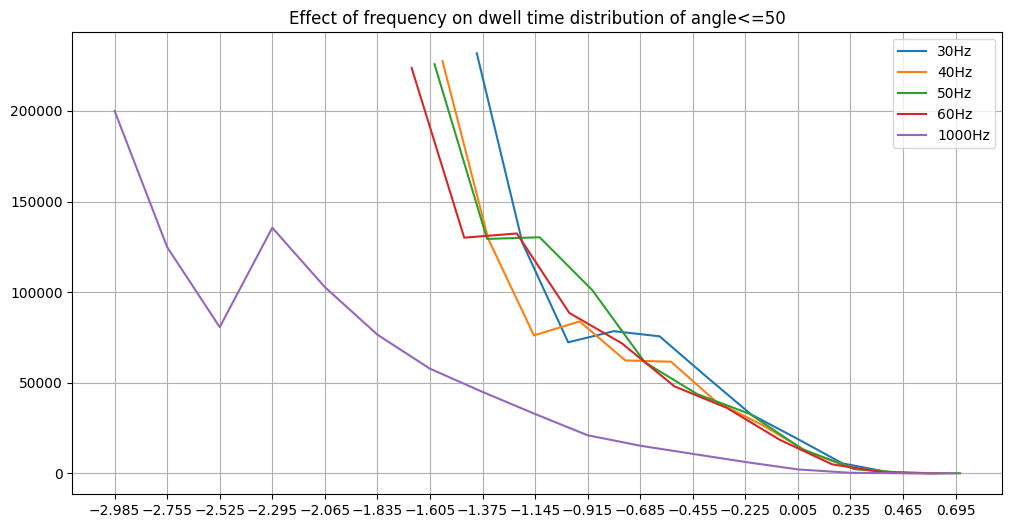

In [27]:

bin_edge1=np.arange(-1.5,0.9,0.2)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
bin_edge2=np.arange(-1.65,0.9,0.2)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2
bin_edge3=np.arange(-1.7,0.9,0.23)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2
bin_edge4=np.arange(-1.8,0.9,0.23)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2
Time1=data1['dwell_time']
Time2=data2['dwell_time']
Time3=data3['dwell_time']
Time4=data4['dwell_time']
Time5=data5['dwell_time']
angle1=data1['angle']
angle2=data2['angle']
angle3=data3['angle']
angle4=data4['angle']
angle5=data5['angle']
angle_1=Time1[angle1<=50/180*np.pi]
angle_2=Time2[angle2<=50/180*np.pi]
angle_3=Time3[angle3<=50/180*np.pi]
angle_4=Time4[angle4<=50/180*np.pi]
angle_5=Time5[angle5<=50/180*np.pi]
hist1,bin1= np.histogram(np.log10(angle_1), bins = bin_edge1)
hist2,bin2= np.histogram(np.log10(angle_2), bins = bin_edge2)
hist3,bin3= np.histogram(np.log10(angle_3), bins = bin_edge3)
hist4,bin4= np.histogram(np.log10(angle_4), bins = bin_edge4)
hist5,bin5= np.histogram(np.log10(angle_5), bins = bin_edge5)
plt.figure(figsize=(12, 6))
plt.plot(bin_center1,hist1,label='30Hz')
plt.plot(bin_center2,hist2,label='40Hz')
plt.plot(bin_center3,hist3,label='50Hz')
plt.plot(bin_center4,hist4,label='60Hz')
plt.plot(bin_center5,hist5,label='1000Hz')
plt.legend()
plt.xticks(bin_center5)
plt.grid()
plt.title("Effect of frequency on dwell time distribution of angle<=50")

Text(0.5, 1.0, 'Effect of frequency on dwell time distribution ')

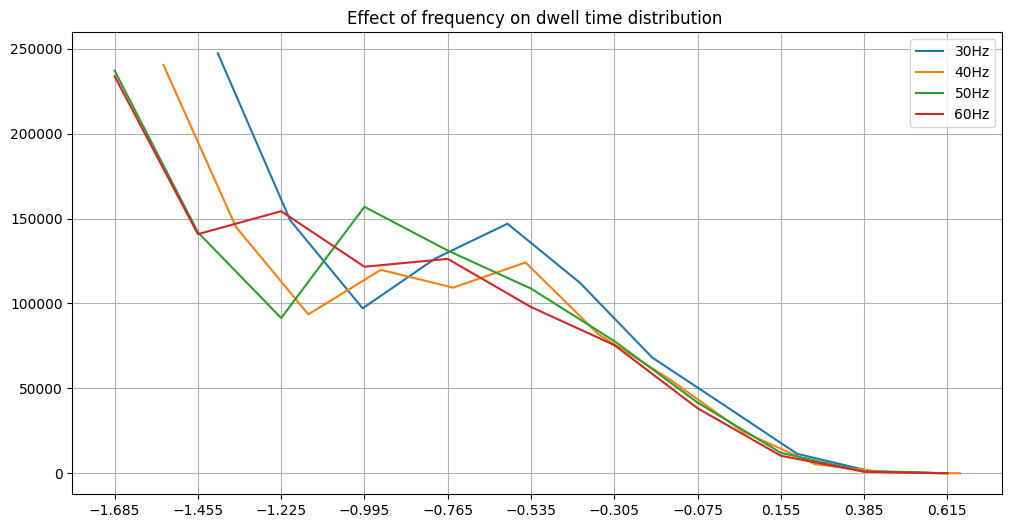

In [53]:
path1 = './1.005_30Hz_step_size=0.04_angle.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')
path2 = './1.005_40Hz_step_size=0.04_angle.xlsx'
data2 = pd.read_excel(path2, sheet_name='dwell time')
path3 = './1.005_50Hz_step_size=0.04_angle.xlsx'
data3 = pd.read_excel(path3, sheet_name='dwell time')
path4 = './1.005_60Hz_step_size=0.04_angle.xlsx'
data4 = pd.read_excel(path4, sheet_name='dwell time')
bin_edge1=np.arange(-1.5,0.9,0.2)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
bin_edge2=np.arange(-1.65,0.9,0.2)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2
bin_edge3=np.arange(-1.8,0.9,0.23)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2
bin_edge4=np.arange(-1.8,0.9,0.23)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2
Time1=data1['dwell_time']
Time2=data2['dwell_time']
Time3=data3['dwell_time']
Time4=data4['dwell_time']
hist1,bin1= np.histogram(np.log10(Time1), bins = bin_edge1)
hist2,bin2= np.histogram(np.log10(Time2), bins = bin_edge2)
hist3,bin3= np.histogram(np.log10(Time3), bins = bin_edge3)
hist4,bin4= np.histogram(np.log10(Time4), bins = bin_edge4)
plt.figure(figsize=(12, 6))
plt.plot(bin_center1,hist1,label='30Hz')
plt.plot(bin_center2,hist2,label='40Hz')
plt.plot(bin_center3,hist3,label='50Hz')
plt.plot(bin_center4,hist4,label='60Hz')
plt.legend()
plt.xticks(bin_center4)
plt.grid()
plt.title("Effect of frequency on dwell time distribution ")

Text(0.5, 1.0, 'Effect of frequency on dwell time distribution of angle<=50')

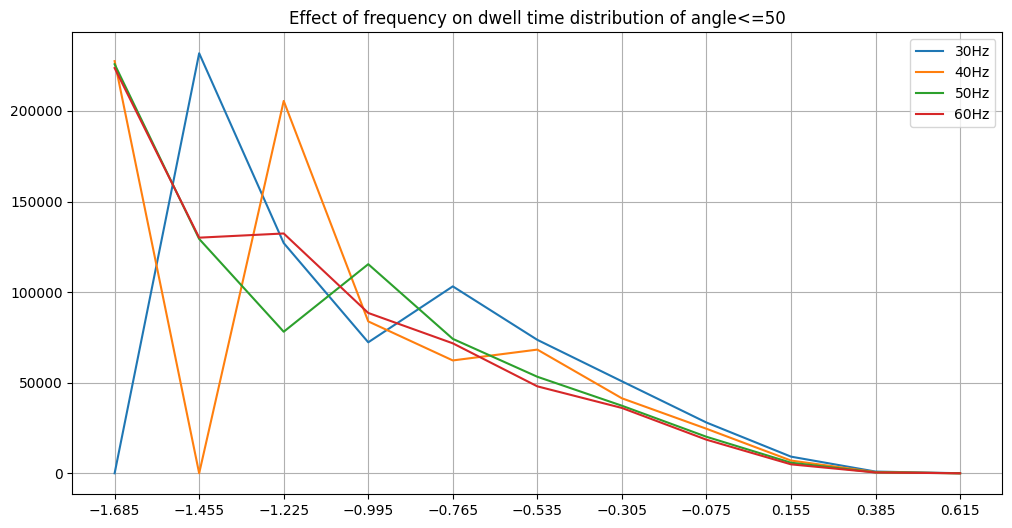

In [ ]:
path1 = './1.005_30Hz_step_size=0.04_angle.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')
path2 = './1.005_40Hz_step_size=0.04_angle.xlsx'
data2 = pd.read_excel(path2, sheet_name='dwell time')
path3 = './1.005_50Hz_step_size=0.04_angle.xlsx'
data3 = pd.read_excel(path3, sheet_name='dwell time')
path4 = './1.005_60Hz_step_size=0.04_angle.xlsx'
data4 = pd.read_excel(path4, sheet_name='dwell time')
bin_edge1=np.arange(-1.5,0.9,0.2)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
bin_edge2=np.arange(-1.65,0.9,0.2)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2
bin_edge3=np.arange(-1.8,0.9,0.23)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2
bin_edge4=np.arange(-1.8,0.9,0.23)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2
Time1=data1['dwell_time']
Time2=data2['dwell_time']
Time3=data3['dwell_time']
Time4=data4['dwell_time']
angle1=data1['angle']
angle2=data2['angle']
angle3=data3['angle']
angle4=data4['angle']
angle_1=Time1[angle1<=50/180*np.pi]
angle_2=Time2[angle2<=50/180*np.pi]
angle_3=Time3[angle3<=50/180*np.pi]
angle_4=Time4[angle4<=50/180*np.pi]
hist1,bin1= np.histogram(np.log10(angle_1), bins = bin_edge4)
hist2,bin2= np.histogram(np.log10(angle_2), bins = bin_edge4)
hist3,bin3= np.histogram(np.log10(angle_3), bins = bin_edge4)
hist4,bin4= np.histogram(np.log10(angle_4), bins = bin_edge4)
plt.figure(figsize=(12, 6))
plt.plot(bin_center4,hist1,label='30Hz')
plt.plot(bin_center4,hist2,label='40Hz')
plt.plot(bin_center4,hist3,label='50Hz')
plt.plot(bin_center4,hist4,label='60Hz')
plt.legend()
plt.xticks(bin_center4)
plt.grid()
plt.title("Effect of frequency on dwell time distribution")

In [84]:
path0= './1.005_30Hz_no_well_step_size=0.04_angle.xlsx'
data0 = pd.read_excel(path0, sheet_name='dwell time')
path1 = './1.005_30Hz_step_size=0.04_angle.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')
path2 = './1.005_40Hz_step_size=0.04_angle.xlsx'
data2 = pd.read_excel(path2, sheet_name='dwell time')
path3 = './1.005_50Hz_step_size=0.04_angle.xlsx'
data3 = pd.read_excel(path3, sheet_name='dwell time')
path4 = './1.005_60Hz_step_size=0.04_angle.xlsx'
data4 = pd.read_excel(path4, sheet_name='dwell time')


(130,)


C:\Users\User\AppData\Local\Temp\ipykernel_75596\2776453638.py:42: RuntimeWarning: divide by zero encountered in log10
  plt.plot(bin_center0,np.nan_to_num(np.log10(hist0), nan=0.0, posinf=0, neginf=0),label='30Hz')
C:\Users\User\AppData\Local\Temp\ipykernel_75596\2776453638.py:43: RuntimeWarning: divide by zero encountered in log10
  plt.plot(bin_center1,np.nan_to_num(np.log10(hist1), nan=0.0, posinf=0, neginf=0),label='30Hz')
C:\Users\User\AppData\Local\Temp\ipykernel_75596\2776453638.py:44: RuntimeWarning: divide by zero encountered in log10
  plt.plot(bin_center2,np.nan_to_num(np.log10(hist2), nan=0.0, posinf=0, neginf=0),label='40Hz')
C:\Users\User\AppData\Local\Temp\ipykernel_75596\2776453638.py:45: RuntimeWarning: divide by zero encountered in log10
  plt.plot(bin_center3,np.nan_to_num(np.log10(hist3), nan=0.0, posinf=0, neginf=0),label='50Hz')
C:\Users\User\AppData\Local\Temp\ipykernel_75596\2776453638.py:46: RuntimeWarning: divide by zero encountered in log10
  plt.plot(bin_ce

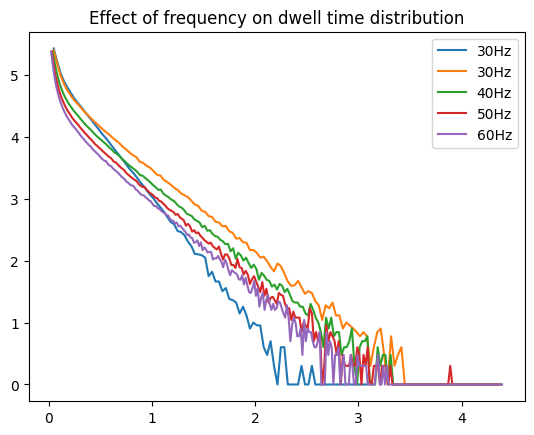

In [86]:
Time0=data0['dwell_time']
angle0=data0['angle']
angle_0=Time0[angle0<=np.pi]
bin_edge0=np.arange(1/30,np.max(Time0),1/30)
bin_center0 = (bin_edge0[:-1] + bin_edge0[1:]) / 2

Time1=data1['dwell_time']
angle1=data1['angle']
angle_1=Time1[angle1<=np.pi]
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2

Time2=data2['dwell_time']
angle2=data2['angle']
angle_2=Time2[angle2<=np.pi]
bin_edge2=np.arange(1/40,np.max(Time2),1/40)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2

Time3=data3['dwell_time']
angle3=data3['angle']
angle_3=Time3[angle3<=np.pi]
bin_edge3=np.arange(1/50,np.max(Time3),1/50)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2

Time4=data4['dwell_time']
angle4=data4['angle']
angle_4=Time4[angle4<=np.pi]
bin_edge4=np.arange(1/60,np.max(Time4),1/60)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2
accuracy=6
hist0,bin1= np.histogram(np.round(angle_0,decimals=accuracy), bins =np.round(bin_edge0,decimals=accuracy))
hist1,bin1= np.histogram(np.round(angle_1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy))
cum1=np.cumsum(hist1)
hist2,bin2= np.histogram(np.round(angle_2,decimals=accuracy), bins =np.round(bin_edge2,decimals=accuracy))
cum2=np.cumsum(hist2)
hist3,bin3= np.histogram(np.round(angle_3,decimals=accuracy), bins =np.round(bin_edge3,decimals=accuracy))
cum3=np.cumsum(hist3)
hist4,bin4= np.histogram(np.round(angle_4,decimals=accuracy), bins =np.round(bin_edge4,decimals=accuracy))
cum4=np.cumsum(hist4)
plt.title("Effect of frequency on dwell time distribution")
print(cum1.shape)
plt.plot(bin_center0,np.nan_to_num(np.log10(hist0), nan=0.0, posinf=0, neginf=0),label='30Hz')
plt.plot(bin_center1,np.nan_to_num(np.log10(hist1), nan=0.0, posinf=0, neginf=0),label='30Hz')
plt.plot(bin_center2,np.nan_to_num(np.log10(hist2), nan=0.0, posinf=0, neginf=0),label='40Hz')
plt.plot(bin_center3,np.nan_to_num(np.log10(hist3), nan=0.0, posinf=0, neginf=0),label='50Hz')
plt.plot(bin_center4,np.nan_to_num(np.log10(hist4), nan=0.0, posinf=0, neginf=0),label='60Hz')
plt.legend()


(130,)


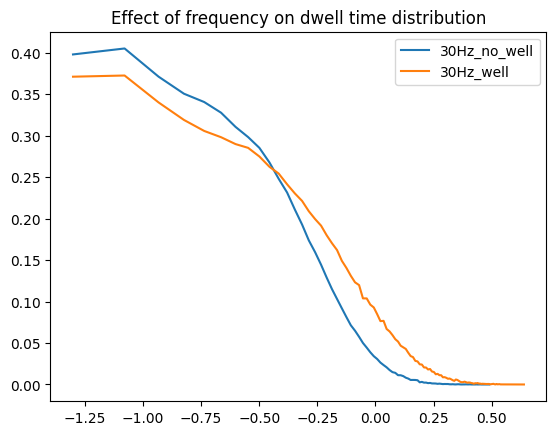

In [88]:
Time0=data0['dwell_time']
angle0=data0['angle']
angle_0=Time0[angle0<=np.pi]
bin_edge0=np.arange(1/30,np.max(Time0),1/30)
bin_center0 = (bin_edge0[:-1] + bin_edge0[1:]) / 2

Time1=data1['dwell_time']
angle1=data1['angle']
angle_1=Time1[angle1<=np.pi]
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2

Time2=data2['dwell_time']
angle2=data2['angle']
angle_2=Time2[angle2<=np.pi]
bin_edge2=np.arange(1/40,np.max(Time2),1/40)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2

Time3=data3['dwell_time']
angle3=data3['angle']
angle_3=Time3[angle3<=np.pi]
bin_edge3=np.arange(1/50,np.max(Time3),1/50)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2

Time4=data4['dwell_time']
angle4=data4['angle']
angle_4=Time4[angle4<=np.pi]
bin_edge4=np.arange(1/60,np.max(Time4),1/60)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2
accuracy=6
hist0,bin1= np.histogram(np.round(angle_0,decimals=accuracy), bins =np.round(bin_edge0,decimals=accuracy),density=True)
hist1,bin1= np.histogram(np.round(angle_1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy),density=True)
cum1=np.cumsum(hist1)
hist2,bin2= np.histogram(np.round(angle_2,decimals=accuracy), bins =np.round(bin_edge2,decimals=accuracy))
cum2=np.cumsum(hist2)
hist3,bin3= np.histogram(np.round(angle_3,decimals=accuracy), bins =np.round(bin_edge3,decimals=accuracy))
cum3=np.cumsum(hist3)
hist4,bin4= np.histogram(np.round(angle_4,decimals=accuracy), bins =np.round(bin_edge4,decimals=accuracy))
cum4=np.cumsum(hist4)
plt.title("Effect of frequency on dwell time distribution")
print(cum1.shape)
plt.plot(np.log10(bin_center0),hist0*bin_center0,label='30Hz_no_well')
plt.plot(np.log10(bin_center1),hist1*bin_center1,label='30Hz_well')
plt.legend()


In [17]:
print(np.nan_to_num(np.log10(hist1), nan=0.0, posinf=0, neginf=0))

[5.39333825 5.17314838 4.98742045 4.85047469 4.7448404  4.66141511
 4.5870596  4.52579607 4.46136345 4.39778363 4.34460838 4.2857148
 4.23200448 4.18358299 4.12949654 4.08217478 4.03905702 3.98775562
 3.94106399 3.89784693 3.84098384 3.79532376 3.74616696 3.70122248
 3.67191301 3.59284268 3.57668681 3.52853106 3.49789674 3.4440448
 3.38471174 3.372912   3.30037806 3.26787542 3.22427401 3.17493159
 3.13987909 3.08421869 3.05461305 3.02448567 2.96473092 2.90579588
 2.88024178 2.80550086 2.78604121 2.7176705  2.70415052 2.62634037
 2.61595005 2.55388303 2.55870857 2.47275645 2.44870632 2.35410844
 2.36361198 2.29666519 2.28780173 2.17026172 2.17026172 2.12385164
 2.04921802 2.06069784 1.99122608 1.89762709 1.8260748  1.95424251
 1.90848502 1.79239169 1.66275783 1.59106461 1.60205999 1.67209786
 1.56820172 1.462398   1.50514998 1.47712125 1.34242268 1.2787536
 1.04139269 1.2787536  1.23044892 1.32221929 1.11394335 1.11394335
 0.90308999 1.         0.95424251 0.90308999 0.84509804 0.7781512

C:\Users\User\AppData\Local\Temp\ipykernel_44292\1067166867.py:1: RuntimeWarning: divide by zero encountered in log10
  print(np.nan_to_num(np.log10(hist1), nan=0.0, posinf=0, neginf=0))


-3.1193713403236276 0.820697989562816


C:\Users\User\AppData\Local\Temp\ipykernel_60488\2056329822.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(bin_center1,np.nan_to_num(np.log(hist1), nan=0.0, posinf=0, neginf=0),label='30Hz')


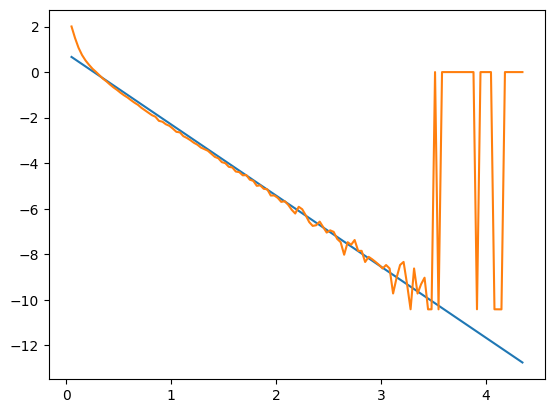

In [16]:

m,c=np.polyfit(bin_center1[:-28],np.nan_to_num(np.log(hist1[:-28]), nan=0.0, posinf=0, neginf=0),deg=1)
print(m,c)
plt.plot(bin_center1,m*bin_center1+c,label='30Hz fit')
plt.plot(bin_center1,np.nan_to_num(np.log(hist1), nan=0.0, posinf=0, neginf=0),label='30Hz')

In [104]:
print(np.exp(-3.1193713403236276))

0.04418493697847316


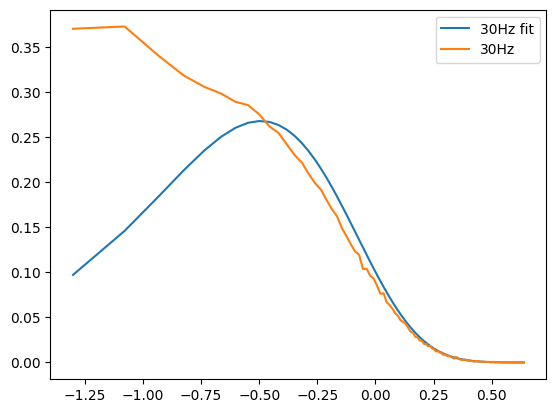

In [17]:
A=np.exp(c)
#bin_edge1=np.arange(1/30,np.max(Time1),1/30)
#bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
plt.plot(np.log10(bin_center1),A*np.exp(m*bin_center1)*bin_center1,label='30Hz fit')
plt.plot(np.log10(bin_center1),hist1*bin_center1,label='30Hz')
plt.legend()

In [31]:
print(A,m)

75740.41034798577 -3.1194059284577773


In [33]:
print(np.log10(A*np.exp(m* bin_edge1)))

[6.91143883 6.64049067 6.36954251 6.09859436 5.8276462  5.55669804
 5.28574989 5.01480173 4.74385358 4.47290542 4.20195726 3.93100911]


(130,)


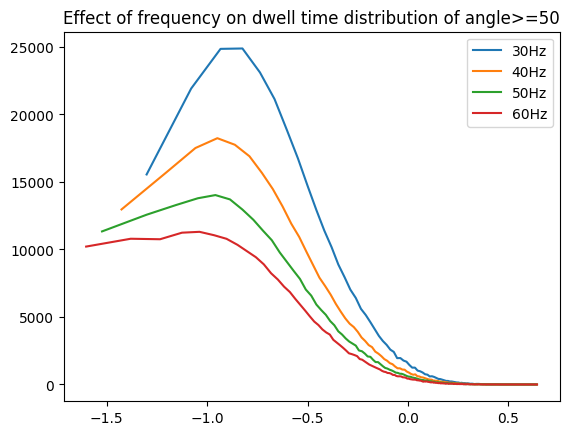

In [8]:

Time1=data1['dwell_time']
angle1=data1['angle']
angle_1=Time1[angle1>=50/180*np.pi]
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2

Time2=data2['dwell_time']
angle2=data2['angle']
angle_2=Time2[angle2>=50/180*np.pi]
bin_edge2=np.arange(1/40,np.max(Time2),1/40)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2

Time3=data3['dwell_time']
angle3=data3['angle']
angle_3=Time3[angle3>=50/180*np.pi]
bin_edge3=np.arange(1/50,np.max(Time3),1/50)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2

Time4=data4['dwell_time']
angle4=data4['angle']
angle_4=Time4[angle4>=50/180*np.pi]
bin_edge4=np.arange(1/60,np.max(Time4),1/60)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2
accuracy=4
hist1,bin1= np.histogram(np.round(angle_1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy))
cum1=np.cumsum(hist1)
hist2,bin2= np.histogram(np.round(angle_2,decimals=accuracy), bins =np.round(bin_edge2,decimals=accuracy))
cum2=np.cumsum(hist2)
hist3,bin3= np.histogram(np.round(angle_3,decimals=accuracy), bins =np.round(bin_edge3,decimals=accuracy))
cum3=np.cumsum(hist3)
hist4,bin4= np.histogram(np.round(angle_4,decimals=accuracy), bins =np.round(bin_edge4,decimals=accuracy))
cum4=np.cumsum(hist4)
plt.title("Effect of frequency on dwell time distribution of angle>=50")
print(cum1.shape)
plt.plot(np.log10(bin_center1),hist1,label='30Hz')
plt.plot(np.log10(bin_center2),hist2,label='40Hz')
plt.plot(np.log10(bin_center3),hist3,label='50Hz')
plt.plot(np.log10(bin_center4),hist4,label='60Hz')
plt.legend()

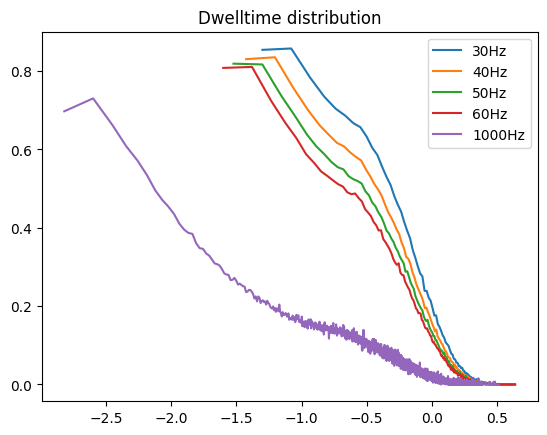

In [31]:

Time1=data1['dwell_time']
angle1=data1['angle']
angle_1=Time1[angle1<=180/180*np.pi]
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2

Time2=data2['dwell_time']
angle2=data2['angle']
angle_2=Time2[angle2<=180/180*np.pi]
bin_edge2=np.arange(1/40,np.max(Time2),1/40)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2

Time3=data3['dwell_time']
angle3=data3['angle']
angle_3=Time3[angle3<=180/180*np.pi]
bin_edge3=np.arange(1/50,np.max(Time3),1/50)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2

Time4=data4['dwell_time']
angle4=data4['angle']
angle_4=Time4[angle4<=180/180*np.pi]
bin_edge4=np.arange(1/60,np.max(Time4),1/60)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2

Time5=data5['dwell_time']
angle5=data5['angle']
angle_5=Time5[angle5<=180/180*np.pi]
bin_edge5=np.arange(1/1000,np.max(Time5),1/1000)
bin_center5 = (bin_edge5[:-1] + bin_edge5[1:]) / 2
accuracy=5
hist1,bin1= np.histogram(np.round(angle_1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy),density=True)
cum1=np.cumsum(hist1)
hist2,bin2= np.histogram(np.round(angle_2,decimals=accuracy), bins =np.round(bin_edge2,decimals=accuracy),density=True)
cum2=np.cumsum(hist2)
hist3,bin3= np.histogram(np.round(angle_3,decimals=accuracy), bins =np.round(bin_edge3,decimals=accuracy),density=True)
cum3=np.cumsum(hist3)
hist4,bin4= np.histogram(np.round(angle_4,decimals=accuracy), bins =np.round(bin_edge4,decimals=accuracy),density=True)
cum4=np.cumsum(hist4)
hist5,bin5= np.histogram(np.round(angle_5,decimals=accuracy), bins =np.round(bin_edge5,decimals=accuracy),density=True)
cum5=np.cumsum(hist5)
plt.title("Effect of frequency on dwell time distribution of angle<=50")
plt.title("Dwelltime distribution")
plt.plot(np.log10(bin_center1),hist1*bin_center1*np.log(10),label='30Hz')
plt.plot(np.log10(bin_center2),hist2*bin_center2*np.log(10),label='40Hz')
plt.plot(np.log10(bin_center3),hist3*bin_center3*np.log(10),label='50Hz')
plt.plot(np.log10(bin_center4),hist4*bin_center4*np.log(10),label='60Hz')
plt.plot(np.log10(bin_center5),hist5*bin_center5*np.log(10),label='1000Hz')
plt.legend()

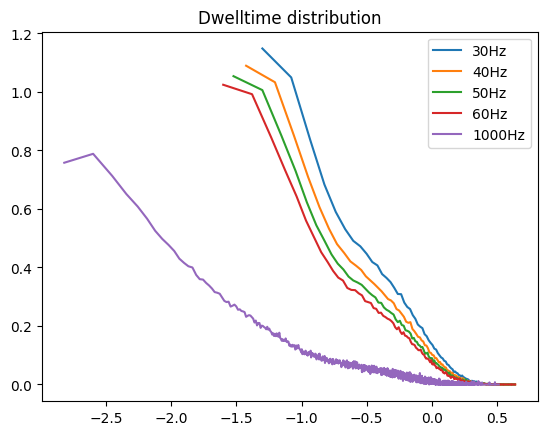

In [32]:

Time1=data1['dwell_time']
angle1=data1['angle']
angle_1=Time1[angle1<=50/180*np.pi]
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2

Time2=data2['dwell_time']
angle2=data2['angle']
angle_2=Time2[angle2<=50/180*np.pi]
bin_edge2=np.arange(1/40,np.max(Time2),1/40)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2

Time3=data3['dwell_time']
angle3=data3['angle']
angle_3=Time3[angle3<=50/180*np.pi]
bin_edge3=np.arange(1/50,np.max(Time3),1/50)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2

Time4=data4['dwell_time']
angle4=data4['angle']
angle_4=Time4[angle4<=50/180*np.pi]
bin_edge4=np.arange(1/60,np.max(Time4),1/60)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2

Time5=data5['dwell_time']
angle5=data5['angle']
angle_5=Time5[angle5<=50/180*np.pi]
bin_edge5=np.arange(1/1000,np.max(Time5),1/1000)
bin_center5 = (bin_edge5[:-1] + bin_edge5[1:]) / 2
accuracy=5
hist1,bin1= np.histogram(np.round(angle_1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy),density=True)
cum1=np.cumsum(hist1)
hist2,bin2= np.histogram(np.round(angle_2,decimals=accuracy), bins =np.round(bin_edge2,decimals=accuracy),density=True)
cum2=np.cumsum(hist2)
hist3,bin3= np.histogram(np.round(angle_3,decimals=accuracy), bins =np.round(bin_edge3,decimals=accuracy),density=True)
cum3=np.cumsum(hist3)
hist4,bin4= np.histogram(np.round(angle_4,decimals=accuracy), bins =np.round(bin_edge4,decimals=accuracy),density=True)
cum4=np.cumsum(hist4)
hist5,bin5= np.histogram(np.round(angle_5,decimals=accuracy), bins =np.round(bin_edge5,decimals=accuracy),density=True)
cum5=np.cumsum(hist5)
plt.title("Effect of frequency on dwell time distribution of angle<=50")
plt.title("Dwelltime distribution")
plt.plot(np.log10(bin_center1),hist1*bin_center1*np.log(10),label='30Hz')
plt.plot(np.log10(bin_center2),hist2*bin_center2*np.log(10),label='40Hz')
plt.plot(np.log10(bin_center3),hist3*bin_center3*np.log(10),label='50Hz')
plt.plot(np.log10(bin_center4),hist4*bin_center4*np.log(10),label='60Hz')
plt.plot(np.log10(bin_center5),hist5*bin_center5*np.log(10),label='1000Hz')
plt.legend()

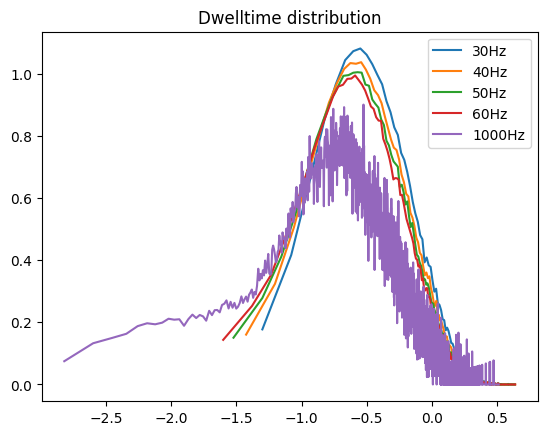

In [35]:

Time1=data1['dwell_time']
angle1=data1['angle']
angle_1=Time1[angle1>=50/180*np.pi]
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2

Time2=data2['dwell_time']
angle2=data2['angle']
angle_2=Time2[angle2>=50/180*np.pi]
bin_edge2=np.arange(1/40,np.max(Time2),1/40)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2

Time3=data3['dwell_time']
angle3=data3['angle']
angle_3=Time3[angle3>=50/180*np.pi]
bin_edge3=np.arange(1/50,np.max(Time3),1/50)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2

Time4=data4['dwell_time']
angle4=data4['angle']
angle_4=Time4[angle4>=50/180*np.pi]
bin_edge4=np.arange(1/60,np.max(Time4),1/60)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2

Time5=data5['dwell_time']
angle5=data5['angle']
angle_5=Time5[angle5>=50/180*np.pi]
bin_edge5=np.arange(1/1000,np.max(Time5),1/1000)
bin_center5 = (bin_edge5[:-1] + bin_edge5[1:]) / 2
accuracy=6
hist1,bin1= np.histogram(np.round(angle_1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy),density=True)
cum1=np.cumsum(hist1)
hist2,bin2= np.histogram(np.round(angle_2,decimals=accuracy), bins =np.round(bin_edge2,decimals=accuracy),density=True)
cum2=np.cumsum(hist2)
hist3,bin3= np.histogram(np.round(angle_3,decimals=accuracy), bins =np.round(bin_edge3,decimals=accuracy),density=True)
cum3=np.cumsum(hist3)
hist4,bin4= np.histogram(np.round(angle_4,decimals=accuracy), bins =np.round(bin_edge4,decimals=accuracy),density=True)
cum4=np.cumsum(hist4)
hist5,bin5= np.histogram(np.round(angle_5,decimals=accuracy), bins =np.round(bin_edge5,decimals=accuracy),density=True)
cum5=np.cumsum(hist5)
plt.title("Effect of frequency on dwell time distribution of angle<=50")
plt.title("Dwelltime distribution")
plt.plot(np.log10(bin_center1),hist1*bin_center1*np.log(10),label='30Hz')
plt.plot(np.log10(bin_center2),hist2*bin_center2*np.log(10),label='40Hz')
plt.plot(np.log10(bin_center3),hist3*bin_center3*np.log(10),label='50Hz')
plt.plot(np.log10(bin_center4),hist4*bin_center4*np.log(10),label='60Hz')
plt.plot(np.log10(bin_center5),hist5*bin_center5*np.log(10),label='1000Hz')
plt.legend()

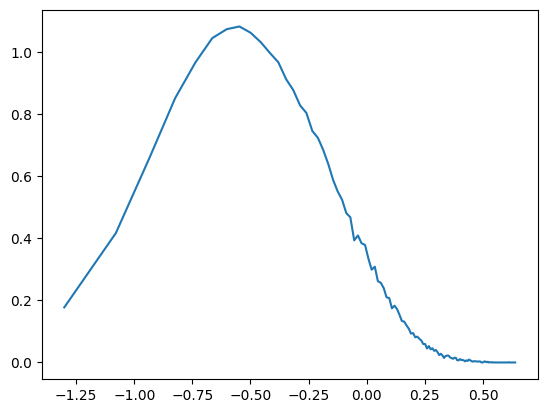

In [ ]:
def f(t,x):
    return t*(1-x)+x*np.log10(t)
def f_dot(t,x):
    return (1-x)+x/t/np.log(10)
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
bin_et=f(bin_edge1,1)
bin_ct=f(bin_center1,1)
bin_ct_dot=f_dot(bin_center1,1)
accuracy=6
Time1=data1['dwell_time']
angle1=data1['angle']
angle_1=Time1[angle1>=50/180*np.pi]
hist,bin= np.histogram(np.round(angle_1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy),density=True)
plt.plot(np.log10(bin_center1),hist1*bin_center1*np.log(10),label='30Hz')

In [ ]:

Time1=data1['dwell_time']
angle1=data1['angle']
angle_1=Time1[angle1<=180/180*np.pi]
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2

Time2=data2['dwell_time']
angle2=data2['angle']
angle_2=Time2[angle2<=180/180*np.pi]
bin_edge2=np.arange(1/40,np.max(Time2),1/40)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2

Time3=data3['dwell_time']
angle3=data3['angle']
angle_3=Time3[angle3<=180/180*np.pi]
bin_edge3=np.arange(1/50,np.max(Time3),1/50)
bin_center3 = (bin_edge3[:-1] + bin_edge3[1:]) / 2

Time4=data4['dwell_time']
angle4=data4['angle']
angle_4=Time4[angle4<=180/180*np.pi]
bin_edge4=np.arange(1/60,np.max(Time4),1/60)
bin_center4 = (bin_edge4[:-1] + bin_edge4[1:]) / 2
accuracy=4
hist1,bin1= np.histogram(np.round(angle_1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy))
cum1=np.cumsum(hist1)
hist2,bin2= np.histogram(np.round(angle_2,decimals=accuracy), bins =np.round(bin_edge2,decimals=accuracy))
cum2=np.cumsum(hist2)
hist3,bin3= np.histogram(np.round(angle_3,decimals=accuracy), bins =np.round(bin_edge3,decimals=accuracy))
cum3=np.cumsum(hist3)
hist4,bin4= np.histogram(np.round(angle_4,decimals=accuracy), bins =np.round(bin_edge4,decimals=accuracy))
cum4=np.cumsum(hist4)
plt.title("Effect of frequency on dwell time distribution of angle<=50")
print(cum1.shape)
plt.plot(np.log10(bin_center1),hist1,label='30Hz')
plt.plot(np.log10(bin_center2),hist2,label='40Hz')
plt.plot(np.log10(bin_center3),hist3,label='50Hz')
plt.plot(np.log10(bin_center4),hist4,label='60Hz')


In [ ]:
plt.figure(figsize=(12, 6))
from scipy.interpolate import CubicSpline
cs = CubicSpline(bin_center1, cum1)
xnew = np.linspace(bin_center1[0], bin_center1[-1], 100)
cum_new = cs(xnew)
plt.plot(bin_center1,cum1,label='30Hz')
plt.plot(xnew,cum_new,label='30Hz')
plt.grid()

plt.figure(figsize=(12, 6))
cs = CubicSpline(np.log10(bin_center1), cum1)
xnew = np.linspace(bin_center1[0], bin_center1[-1], 100)
cum_new = cs(np.log10(xnew))
plt.plot(np.log10(bin_center1),cum1,label='30Hz')
plt.plot(np.log10(xnew),cum_new,label='30Hz')
plt.grid()
print(bin_edge1.shape)

plt.figure(figsize=(12, 6))
cs = CubicSpline(np.log10(bin_center1), cum1)
xnew = np.linspace(bin_center1[0], bin_center1[-1], 100)
cum_new = cs(np.log10(xnew),1)
plt.plot(np.log10(xnew),cum_new,label='30Hz')
plt.grid()

[-1.385 -1.155 -0.925 -0.695 -0.465 -0.235 -0.005  0.225  0.455  0.685]


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


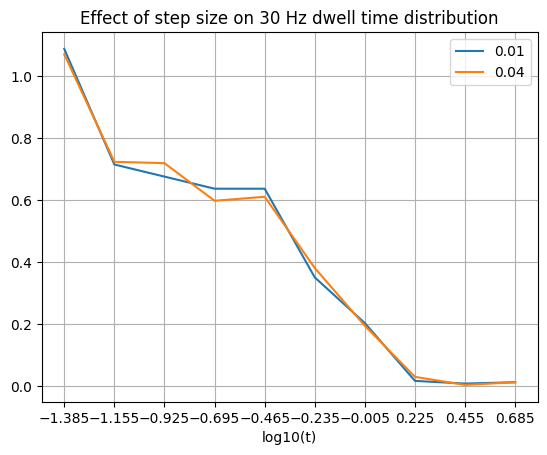

In [ ]:
path3 = './1.005_30Hz_step_size=0.01_trial1.xlsx'
path4 = './1.005_30Hz_step_size=0.04_trial1.xlsx'
data3 = pd.read_excel(path3, sheet_name='dwell time')
data4 = pd.read_excel(path4, sheet_name='dwell time')
bin_edge2=np.arange(-1.5,0.9,0.23)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2
hist3,bin3= np.histogram(np.log10(data3), bins = bin_edge2,density=True)
hist4,bin4= np.histogram(np.log10(data4), bins = bin_edge2,density=True)
print(bin_center2)
plt.plot(bin_center2,hist3,label='0.01')
plt.plot(bin_center2,hist4,label='0.04')
plt.title("Effect of step size on 30 Hz dwell time distribution")
plt.xticks(bin_center2)
plt.xlabel("log10(t)")
plt.grid()
plt.legend()

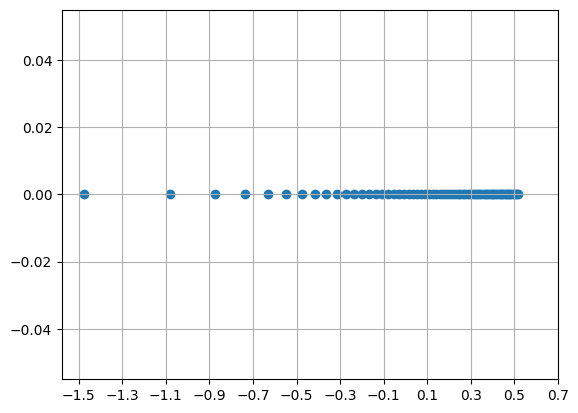

In [ ]:
frequency=30
bin=np.log10(np.arange(1/frequency,100/frequency,step=1/20))
plt.scatter(bin,np.zeros_like(bin))
plt.xticks(bin_edge1)
plt.grid()

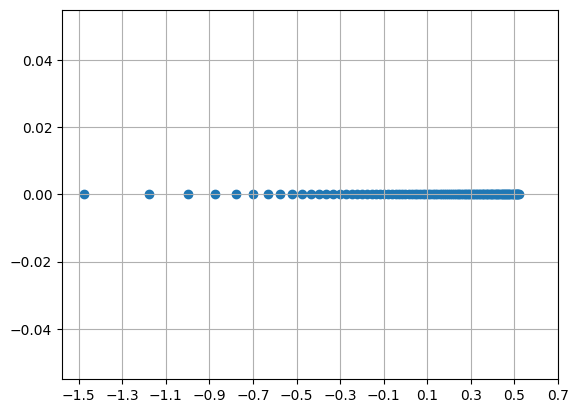

In [ ]:
frequency=30
bin=np.log10(np.arange(1/frequency,100/frequency,step=1/frequency))
plt.scatter(bin,np.zeros_like(bin))
plt.xticks(bin_edge2)
plt.grid()

-1.6020599913279623


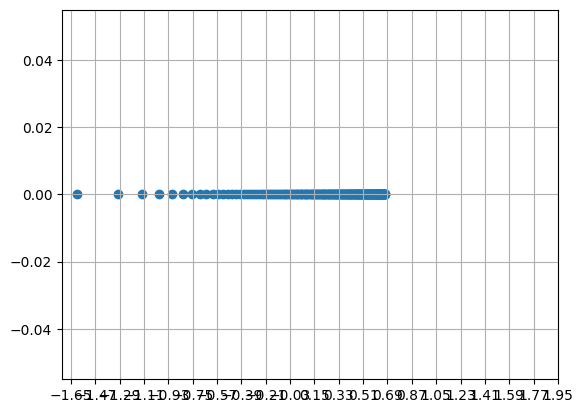

In [ ]:
frequency=40
bin_edge3=np.arange(-1.65,2,0.18)
bin=np.log10(np.arange(1/frequency,190/frequency,step=1/frequency))
print(bin[0])
plt.scatter(bin,np.zeros_like(bin))
plt.xticks(bin_edge3)
plt.grid()

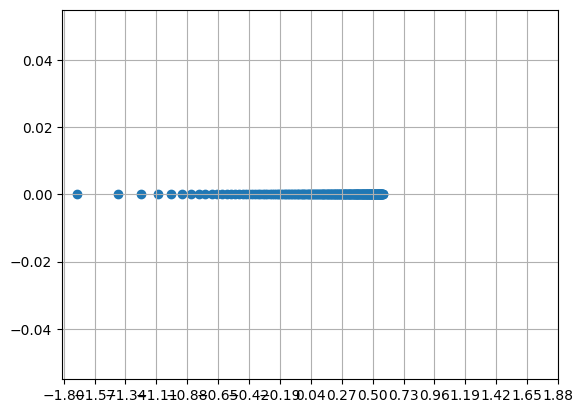

In [ ]:
frequency=50
bin_edge3=np.arange(-1.8,2,0.23)
bin=np.log10(np.arange(1/frequency,190/frequency,step=1/frequency))
plt.scatter(bin,np.zeros_like(bin))
plt.xticks(bin_edge3)
plt.grid()

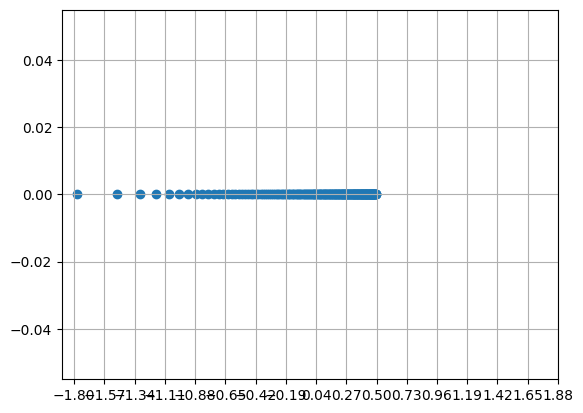

In [ ]:
frequency=60
bin_edge3=np.arange(-1.8,2,0.23)
bin=np.log10(np.arange(1/frequency,190/frequency,step=1/frequency))
plt.scatter(bin,np.zeros_like(bin))
plt.xticks(bin_edge3)
plt.grid()

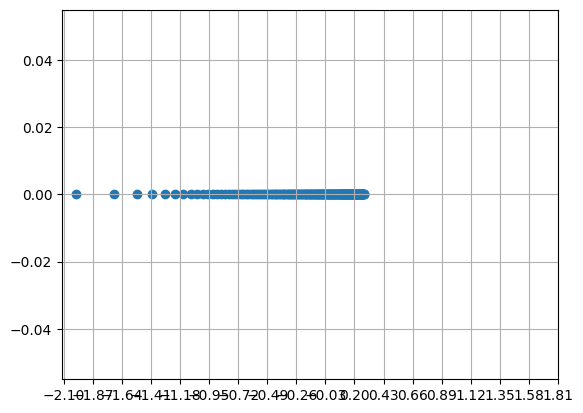

In [ ]:
frequency=100
bin_edge3=np.arange(-2.1,2,0.23)
bin=np.log10(np.arange(1/frequency,190/frequency,step=1/frequency))
plt.scatter(bin,np.zeros_like(bin))
plt.xticks(bin_edge3)
plt.grid()

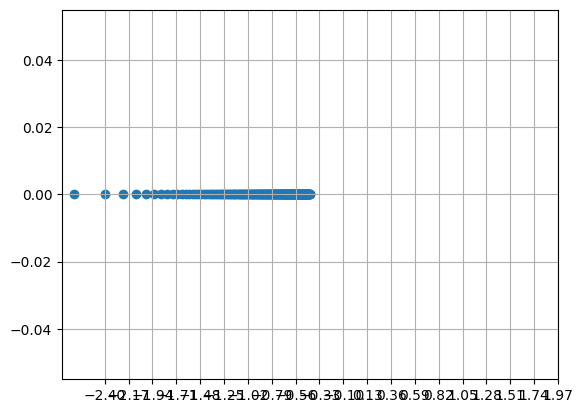

In [ ]:
frequency=500
bin_edge3=np.arange(-2.4,2,0.23)
bin=np.log10(np.arange(1/frequency,190/frequency,step=1/frequency))
plt.scatter(bin,np.zeros_like(bin))
plt.xticks(bin_edge3)
plt.grid()

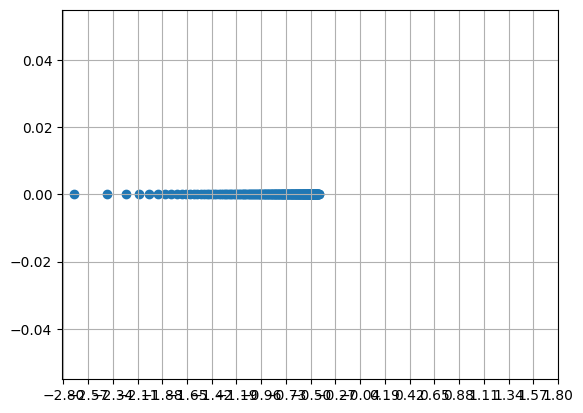

In [ ]:
frequency=500
bin_edge3=np.arange(-2.8,2,0.23)
bin=np.log10(np.arange(1/frequency,190/frequency,step=1/frequency))
plt.scatter(bin,np.zeros_like(bin))
plt.xticks(bin_edge3)
plt.grid()

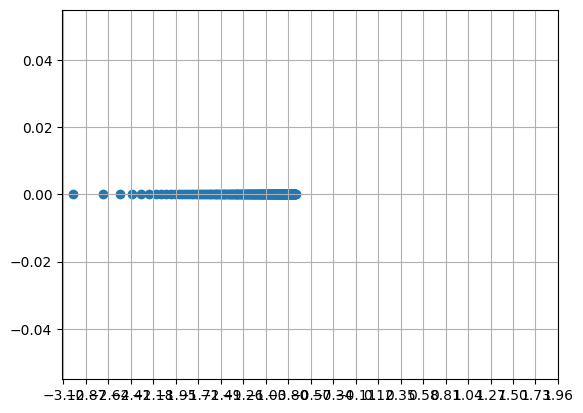

In [ ]:
frequency=1000
bin_edge3=np.arange(-3.1,2,0.23)
bin=np.log10(np.arange(1/frequency,190/frequency,step=1/frequency))
plt.scatter(bin,np.zeros_like(bin))
plt.xticks(bin_edge3)
plt.grid()

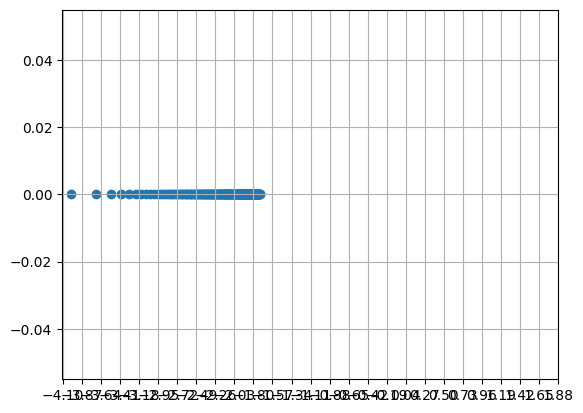

In [ ]:
frequency=10000
bin_edge3=np.arange(-4.1,2,0.23)
bin=np.log10(np.arange(1/frequency,190/frequency,step=1/frequency))
plt.scatter(bin,np.zeros_like(bin))
plt.xticks(bin_edge3)
plt.grid()

0      0.075
1      0.050
2      0.100
3      0.025
4      0.100
       ...  
992    0.025
993    0.025
994    0.100
995    0.175
996    0.125
Name: dwell_time, Length: 997, dtype: float64
(13,)
[1.0985337  0.74986865 0.46807088 0.83584086 0.52538568 0.45851841
 0.34866504 0.22925921 0.04776233 0.         0.         0.        ]


([<matplotlib.axis.XTick at 0x25995aa8bd0>,
 [Text(-3.9849999999999994, 0, '−3.985'),
  Text(-3.755, 0, '−3.755'),
  Text(-3.5249999999999995, 0, '−3.525'),
  Text(-3.295, 0, '−3.295'),
  Text(-3.0649999999999995, 0, '−3.065'),
  Text(-2.835, 0, '−2.835'),
  Text(-2.6049999999999995, 0, '−2.605'),
  Text(-2.375, 0, '−2.375'),
  Text(-2.1449999999999996, 0, '−2.145'),
  Text(-1.9149999999999998, 0, '−1.915'),
  Text(-1.6849999999999998, 0, '−1.685'),
  Text(-1.4549999999999998, 0, '−1.455'),
  Text(-1.2249999999999999, 0, '−1.225'),
  Text(-0.9949999999999999, 0, '−0.995'),
  Text(-0.7649999999999999, 0, '−0.765'),
  Text(-0.5349999999999999, 0, '−0.535'),
  Text(-0.30499999999999994, 0, '−0.305'),
  Text(-0.07499999999999996, 0, '−0.075'),
  Text(0.1549999999999998, 0, '0.155'),
  Text(0.3849999999999998, 0, '0.385'),
  Text(0.6150000000000002, 0, '0.615')])

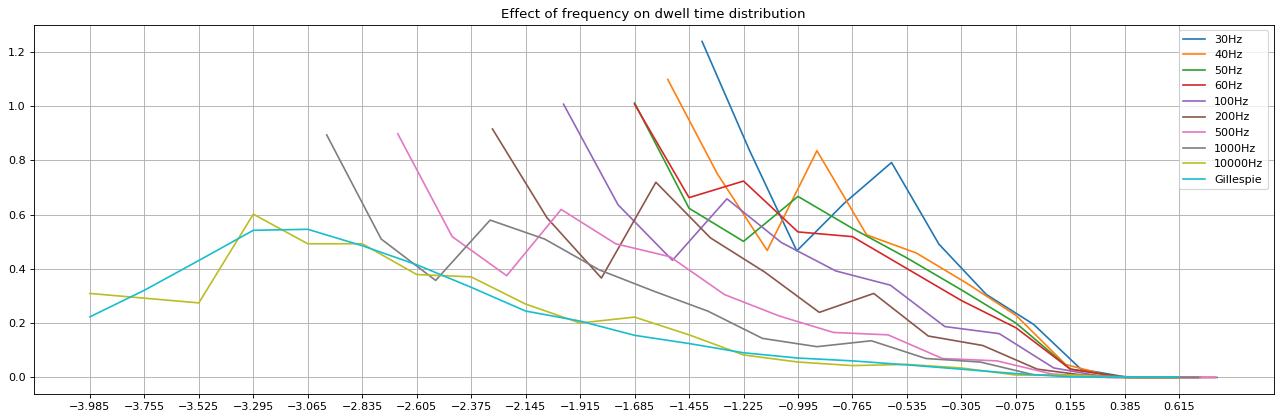

In [ ]:
plt.figure(figsize=(20, 6), dpi=80)
bin_edge1=np.arange(-1.5,0.9,0.3)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
bin_edge2=np.arange(-1.5,0.9,0.2)
bin_center2 = (bin_edge2[:-1] + bin_edge2[1:]) / 2
bin_edge3=np.arange(-1.65,0.9,0.21)
bin_center3= (bin_edge3[:-1] + bin_edge3[1:]) / 2
bin_edge4=np.arange(-1.8,0.9,0.23)
bin_center4= (bin_edge4[:-1] + bin_edge4[1:]) / 2
bin_edge5=np.arange(-1.8,0.9,0.23)
bin_center5= (bin_edge5[:-1] + bin_edge5[1:]) / 2
bin_edge6=np.arange(-2.1,0.9,0.23)
bin_center6= (bin_edge6[:-1] + bin_edge6[1:]) / 2
bin_edge7=np.arange(-2.4,0.9,0.23)
bin_center7= (bin_edge7[:-1] + bin_edge7[1:]) / 2
bin_edge8=np.arange(-2.8,0.9,0.23)
bin_center8= (bin_edge8[:-1] + bin_edge8[1:]) / 2
bin_edge9=np.arange(-3.1,0.9,0.23)
bin_center9= (bin_edge9[:-1] + bin_edge9[1:]) / 2
bin_edge10=np.arange(-4.1,0.9,0.23)
bin_center10= (bin_edge10[:-1] + bin_edge10[1:]) / 2
path2 = './1.005_20Hz_step_size=0.04_trial1.xlsx'
path4 = './1.005_30Hz_step_size=0.04_trial1.xlsx'
path5 = './1.005_40Hz_step_size=0.04_trial1.xlsx'
path6 = './1.005_50Hz_step_size=0.04_trial1.xlsx'
path7 = './1.005_60Hz_step_size=0.04_trial1.xlsx'
path8 = './1.005_100Hz_step_size=0.04_trial1.xlsx'
path9 = './1.005_200Hz_step_size=0.04_trial1.xlsx'
path10 = './1.005_500Hz_step_size=0.04_trial1.xlsx'
path11 = './1.005_1000Hz_step_size=0.04_trial1.xlsx'
path13 = './1.005_10000Hz_step_size=0.04_trial1.xlsx'
data2 = pd.read_excel(path2, sheet_name='dwell time')
data4 = pd.read_excel(path4, sheet_name='dwell time')
data5 = pd.read_excel(path5, sheet_name='dwell time')
data6= pd.read_excel(path6, sheet_name='dwell time')
data7= pd.read_excel(path7, sheet_name='dwell time')
data8= pd.read_excel(path8, sheet_name='dwell time')
data9= pd.read_excel(path9, sheet_name='dwell time')
data10= pd.read_excel(path10, sheet_name='dwell time')
data11= pd.read_excel(path11, sheet_name='dwell time')
data13= pd.read_excel(path13, sheet_name='dwell time')
hist2,bin2= np.histogram(np.log10(data2["dwell_time"]), bins = bin_edge1,density=True)
hist4,bin4= np.histogram(np.log10(data4["dwell_time"]), bins = bin_edge2,density=True)
hist5,bin5= np.histogram(np.log10(data5["dwell_time"]), bins = bin_edge3,density=True)
print(data5["dwell_time"])
hist6,bin6= np.histogram(np.log10(data6["dwell_time"]), bins = bin_edge4,density=True)
hist7,bin7= np.histogram(np.log10(data7["dwell_time"]), bins = bin_edge5,density=True)
hist8,bin8= np.histogram(np.log10(data8["dwell_time"]), bins = bin_edge6,density=True)
hist9,bin9= np.histogram(np.log10(data9["dwell_time"]), bins = bin_edge7,density=True)
hist10,bin10= np.histogram(np.log10(data10["dwell_time"]), bins = bin_edge8,density=True)
hist11,bin11= np.histogram(np.log10(data11["dwell_time"]), bins = bin_edge9,density=True)
hist13,bin13= np.histogram(np.log10(data13["dwell_time"]), bins = bin_edge10,density=True)
print(bin_edge3.shape)
print(hist5)
#plt.plot(bin_center1,hist2,label='20Hz')
plt.plot(bin_center2,hist4,label='30Hz')
plt.plot(bin_center3,hist5,label='40Hz')
plt.plot(bin_center4,hist6,label='50Hz')
plt.plot(bin_center5,hist7,label='60Hz')
plt.plot(bin_center6,hist8,label='100Hz')
plt.plot(bin_center7,hist9,label='200Hz')
plt.plot(bin_center8,hist10,label='500Hz')
plt.plot(bin_center9,hist11,label='1000Hz')
plt.plot(bin_center10,hist13,label='10000Hz')
path12 = './1.005_Gilles_step_size=0.04_trial1.xlsx'
data12 = pd.read_excel(path12, sheet_name='dwell time')
hist12,bin12= np.histogram(np.log10(data12[1:]), bins = np.arange(-4.1,0.9,0.23),density=True)
plt.plot((bin12[:-1] + bin12[1:]) / 2,hist12,label='Gillespie')
plt.grid()
plt.title("Effect of frequency on dwell time distribution")
plt.legend()
plt.xticks(bin_center10)

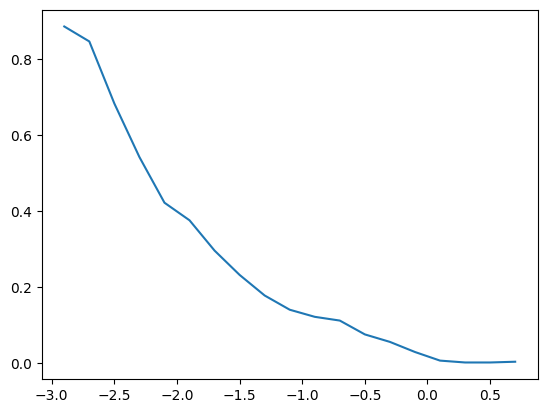

In [ ]:
path12 = './1.005_Gilles_step_size=0.04_trial1.xlsx'
data12 = pd.read_excel(path12, sheet_name='dwell time')
hist12,bin12= np.histogram(np.log10(data12[1:]), bins = np.arange(-3,0.9,0.2),density=True)
plt.plot((bin12[:-1] + bin12[1:]) / 2,hist12,label='Gillespie')

[-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6  1.8]


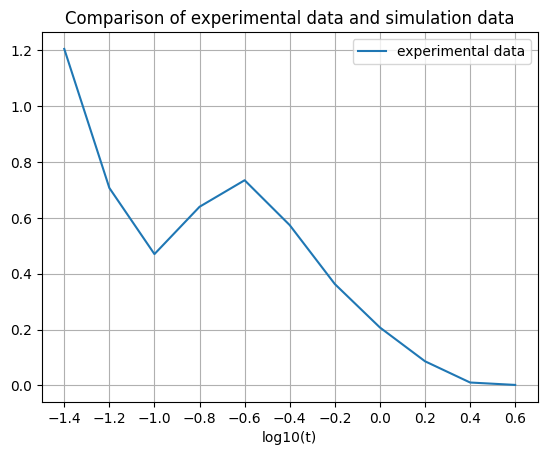

In [ ]:
bin_edge5=np.array([-1.5,-1.3,-1.1,-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9])
frequency5=np.array([453.0,242,151,167,129,85,31,7,2,0,0,0,0,0,0,0,0])
frequency6=np.array([697.0, 409, 272, 370, 425, 332, 210, 120, 50, 6, 1, 0, 0, 0, 0, 0, 0])
#print(bin_edge5.shape,frequency5.shape)
Factual = np.cumsum(frequency6)*(bin_edge5[1]-bin_edge5[0])
frequency6/=Factual[-1]
#bin_edge5=np.append(bin_edge5,2.1)

bin_center5=(bin_edge5[:-1]+bin_edge5[1:])/2
bin_center5=(bin_edge5[:-1]+bin_edge5[1:])/2
print(bin_center5)
#print(bin_center2)
plt.plot(bin_center5[:-6],frequency6[:-6] ,label='experimental data')
#plt.plot(bin_center2,hist4,label='0.04')
plt.title("Comparison of experimental data and simulation data")
plt.xticks(bin_center5[:-6])
plt.xlabel("log10(t)")
plt.grid()
plt.legend()

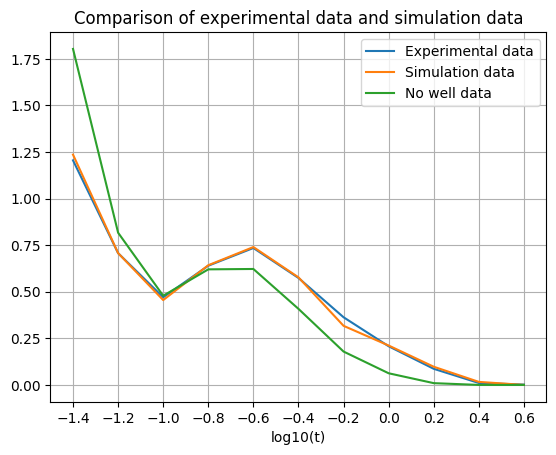

In [ ]:
frequency7 = np.array([152.0, 87, 56, 79, 91, 71, 39, 26, 12, 2, 0, 0, 0, 0, 0, 0, 0])
bin_edge5=np.array([-1.5,-1.3,-1.1,-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9])
Factual2 = np.cumsum(frequency7)*(bin_edge5[1]-bin_edge5[0])
frequency7/=Factual2[-1]
bin_center6=(bin_edge5[:-1]+bin_edge5[1:])/2
path1 = './Monte_Carlo1.005_30Hz_control.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')
bin_edge1=np.arange(-1.5,0.9,0.2)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
hist1,bin1= np.histogram(np.log10(data1["dwell_time"]), bins = bin_edge1,density=True)
plt.plot(bin_center5[:-6],frequency6[:-6] ,label='Experimental data')
plt.plot(bin_center6[:-6],frequency7[:-6],label='Simulation data')
plt.plot(bin_center1,hist1,label='No well data')
plt.title("Comparison of experimental data and simulation data")
plt.xticks(bin_center5[:-6])
plt.xlabel("log10(t)")
plt.grid()
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (11,) and (7,)

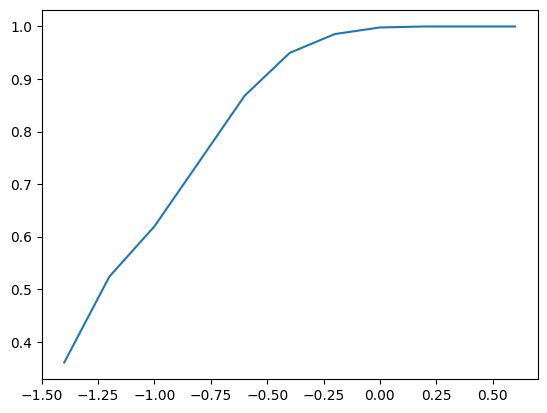

In [ ]:
dx1 = bin1[1] -bin1[0]
dx2 = bin1[1] -bin1[0]
F1 = np.cumsum(hist1)*dx1
F2 = np.cumsum(hist2)*dx2
plt.plot(bin_center1, F1,label='0.01')
plt.plot(bin_center1, F2,label='0.04')
plt.xticks(bin_center1)
plt.title("Cummulative distribution of dwell time")
plt.grid()
plt.legend()

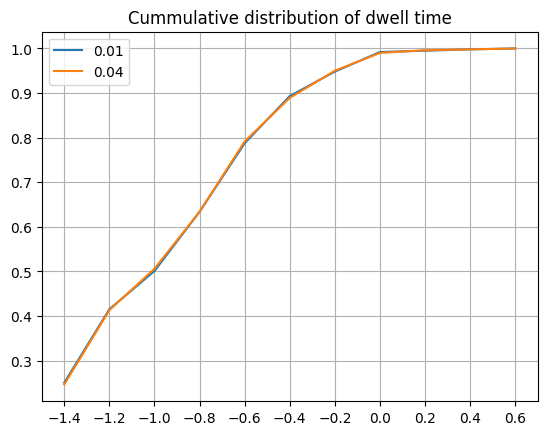

In [ ]:
dx3 = bin3[1] -bin3[0]
dx4 = bin3[1] -bin3[0]
F3 = np.cumsum(hist3)*dx3
F4 = np.cumsum(hist4)*dx4
plt.plot(bin_center2, F3,label='0.01')
plt.plot(bin_center2, F4,label='0.04')
plt.xticks(bin_center2)
plt.title("Cummulative distribution of dwell time")
plt.grid()
plt.legend()

0.04003403980420894


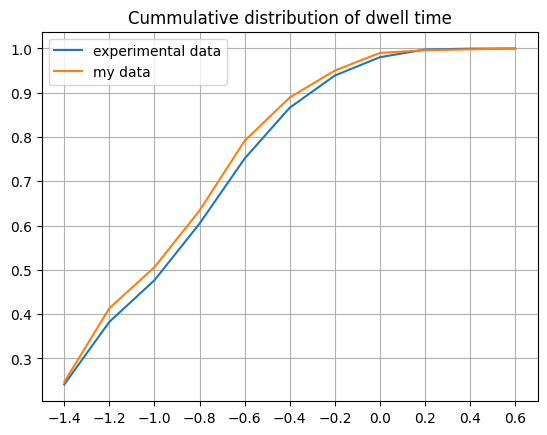

In [ ]:
dx3 = bin3[1] -bin3[0]
dx4 = bin3[1] -bin3[0]
F5 = np.cumsum(frequency6[:-6])*dx3
F4 = np.cumsum(hist4)*dx4
plt.plot(bin_center2, F5,label='experimental data')
plt.plot(bin_center2, F4,label='my data')
plt.xticks(bin_center2)
plt.title("Cummulative distribution of dwell time")
plt.grid()
plt.legend()
KS_stat=np.max(np.abs(F5-F4))
print(KS_stat)

0.006183584657423302


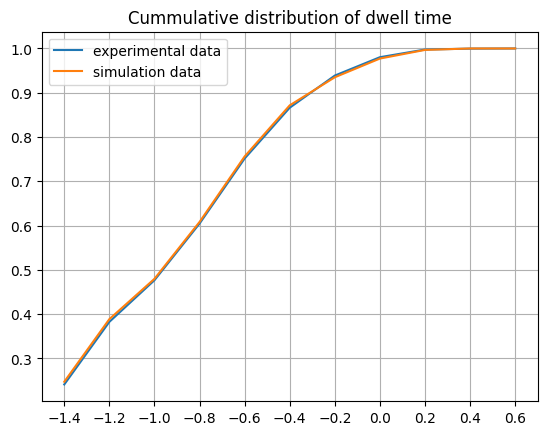

In [ ]:
dx3 = bin3[1] -bin3[0]
dx4 = bin3[1] -bin3[0]
F6= np.cumsum(frequency6[:-6])*dx3
F7 = np.cumsum(frequency7[:-6])*dx4
plt.plot(bin_center2, F6,label='experimental data')
plt.plot(bin_center2, F7,label='simulation data')
plt.xticks(bin_center2)
plt.title("Cummulative distribution of dwell time")
plt.grid()
plt.legend()
KS_stat=np.max(np.abs(F6-F7))
print(KS_stat)

In [49]:
path1 = './1.005_30Hz_step_size=0.04_angle_below_z.xlsx'
data1 = pd.read_excel(path1, sheet_name='dwell time')
bin_edge1=np.arange(-1.5,0.9,0.2)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2

Time1=data1['dwell_time']
hist1,bin1= np.histogram(np.log10(Time1), bins = bin_edge1)


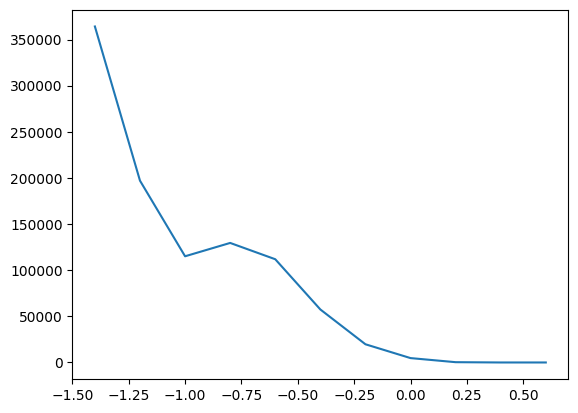

In [50]:
plt.plot(bin_center1,hist1,label='30Hz')

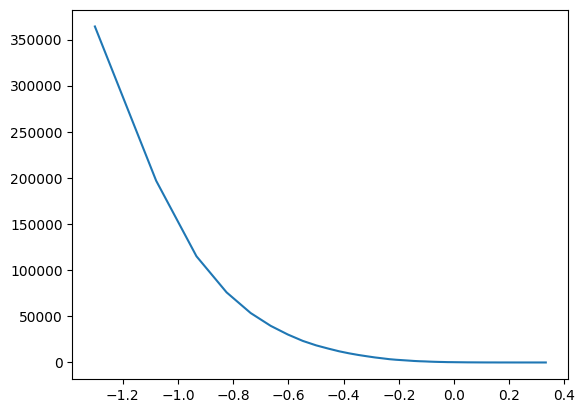

In [53]:
angle1=data1['angle']
angle_1=Time1[angle1<=np.pi]
bin_edge1=np.arange(1/30,np.max(Time1),1/30)
bin_center1 = (bin_edge1[:-1] + bin_edge1[1:]) / 2
hist1,bin1= np.histogram(Time1, bins = bin_edge1)
accuracy=4
hist1,bin1= np.histogram(np.round(angle_1,decimals=accuracy), bins =np.round(bin_edge1,decimals=accuracy))
plt.plot(np.log10(bin_center1),hist1,label='30Hz')